In [1]:
EXPERIMENT = '05-11'
N_SPLITS = 5
SEED = 1
CLIP_UPPER_RATE = 1.5
CLIP_LOWER_RATE = 1.0
Y_THRESHOLD = 200

In [2]:
from collections import defaultdict
import configparser
from functools import partial
from itertools import chain
import json
import logging
import os
import pickle
import re
import sys
import time

SINCE = time.time()

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearnex import patch_sklearn

config = configparser.ConfigParser()
INI_FILEPATH = os.path.join(os.path.expanduser('~'), 'aiquest2021-assesment', 'config.ini')
config.read(INI_FILEPATH)
if config['FOLDER']['SCRIPTS'] not in sys.path:
    sys.path.append(config['FOLDER']['SCRIPTS'])
from logging_util import get_logger, timer
from feature_engineering import make_or_load_features
from text_feature_extraction import make_or_load_vector

In [3]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
output_dir = os.path.join(config['FOLDER']['EXPERIMENTS'], EXPERIMENT)
os.makedirs(output_dir)

In [5]:
logger = get_logger(__name__, os.path.join(output_dir, 'log.log'))

# Loading

In [6]:
with timer('Load dataset', logger):
    train = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'train.csv'))
    test = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'test.csv'))
    sample_submit = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'sample_submit.csv'))

# Feature engineering

In [7]:
train_path = os.path.join(config['FOLDER']['FEATURES'], 'train_features.csv')
test_path = os.path.join(config['FOLDER']['FEATURES'], 'test_features.csv')

In [8]:
X, X_test = make_or_load_features(train, test, train_path, test_path, logger)

In [9]:
X

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,1.0,4.0,0,0,1,1,...,0,0,0,1,2016.0,7.0,2016.0,7.0,2016.0,7.0
1,1,2,1.0,0,1.0,1.0,1,1,1,1,...,1,1,0,0,2016.0,9.0,2015.0,12.0,2017.0,3.0
2,2,2,2.0,0,1.0,1.0,1,2,1,1,...,2,2,1,0,2016.0,6.0,2016.0,5.0,2017.0,8.0
3,3,2,1.0,0,1.0,1.0,1,3,1,1,...,0,3,0,1,2014.0,3.0,2012.0,6.0,2017.0,9.0
4,4,2,1.0,0,1.0,1.0,1,2,1,1,...,2,4,0,0,2015.0,8.0,2015.0,3.0,2017.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55578,55578,4,1.5,0,1.0,1.0,1,2,1,1,...,2,95,0,0,2013.0,2.0,2013.0,1.0,2017.0,9.0
55579,55579,2,1.0,0,1.0,1.0,2,4,0,1,...,3,181,0,0,2015.0,11.0,2015.0,1.0,2016.0,10.0
55580,55580,2,1.0,0,1.0,1.0,0,3,1,1,...,0,33,0,0,2016.0,3.0,2016.0,2.0,2017.0,4.0
55581,55581,1,1.5,0,1.0,1.0,2,0,1,1,...,0,251,0,0,2016.0,10.0,2016.0,4.0,2017.0,4.0


In [10]:
X_test

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,2.0,2.0,1,5,1,1,...,4,88,0,0,2017.0,1.0,2016.0,8.0,2017.0,9.0
1,1,3,1.0,0,1.0,1.0,2,0,1,1,...,0,16,0,0,2016.0,8.0,2014.0,9.0,2017.0,5.0
2,2,2,1.0,0,0.0,1.0,0,2,0,1,...,2,90,0,0,NaN,NaN,2012.0,10.0,NaN,NaN
3,3,4,1.0,0,1.0,2.0,1,2,0,1,...,2,44,0,0,NaN,NaN,2013.0,1.0,NaN,NaN
4,4,3,1.5,0,1.0,2.0,1,0,1,1,...,0,129,0,0,2015.0,8.0,2014.0,12.0,2016.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,18523,4,1.0,0,2.0,2.0,1,2,1,1,...,2,109,0,0,NaN,NaN,2009.0,11.0,NaN,NaN
18524,18524,2,1.0,0,2.0,1.0,0,4,0,1,...,3,22,0,1,2017.0,1.0,2017.0,1.0,2017.0,4.0
18525,18525,5,1.5,0,2.0,2.0,0,4,1,1,...,3,181,0,0,NaN,NaN,2014.0,9.0,NaN,NaN
18526,18526,2,1.0,0,1.0,2.0,1,2,1,1,...,2,158,0,0,2016.0,4.0,2014.0,3.0,2017.0,5.0


In [11]:
X.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]
X_test.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]

In [12]:
# Clustering
area_features = ['latitude', 'longitude']

# Onehot encoding
categorical_features = ['cancellation_policy', 'bed_type', 'city', 'neighbourhood', 'property_type',
                        'room_type', 'zipcode5', 'zipcode_1st_digit']

# They do not need to be encoded
int_flag_features = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
                     'instant_bookable', 'has_thumbnail', 'zipcode_imputed']

# Already one-hot style
amenity_onehot_features = [c for c in X.columns if c.startswith('has_') and c.endswith('_amenity')]

discrete_features = categorical_features + int_flag_features + amenity_onehot_features

# Scaling, transformation
continuous_features = [
    c for c in X.columns
    if c not in discrete_features + area_features + ['id', 'y']
]

In [13]:
%%time
# Reduce dimension & whitening
## training
decomposer = PCA(n_components=0.8, random_state=SEED, whiten=True).fit(X[amenity_onehot_features])
X_amenity_components = decomposer.transform(X[amenity_onehot_features])
amenity_components_columns = [f'amenity_x{i + 1}' for i in range(decomposer.n_components_)]
X_amenity_components = pd.DataFrame(data=X_amenity_components,
                                    columns=amenity_components_columns)
X = pd.concat([X, X_amenity_components], axis=1)
# X.drop(columns=amenity_onehot_features, inplace=True)
X_test_amenity_components = decomposer.transform(X_test[amenity_onehot_features])
X_test_amenity_components = pd.DataFrame(data=X_test_amenity_components,
                                         columns=amenity_components_columns)
X_test = pd.concat([X_test, X_test_amenity_components], axis=1)
# X_test.drop(columns=amenity_onehot_features, inplace=True)

Wall time: 545 ms


In [14]:
f = lambda s1, s2: ' '.join([s1, s2])
train['name+description'] = np.vectorize(f)(train['name'], train['description'])
test['name+description'] = np.vectorize(f)(test['name'], test['description'])

In [15]:
%%time
vec_train, vec_test = make_or_load_vector(train=train,
                                          test=test,
                                          feature_dir=config['FOLDER']['FEATURES'],
                                          logger=logger,
                                          text_column='name+description',
                                          embedder='lda_count',
                                          overwrite=True,
                                          random_state=85)

Wall time: 4min 45s


In [16]:
%%time
vec_columns = vec_train.columns.tolist()

Wall time: 0 ns


In [17]:
%%time
X = pd.concat([X, vec_train], axis=1)
X_test = pd.concat([X_test, vec_test], axis=1)
X.shape, X_test.shape

Wall time: 74 ms


((55583, 285), (18528, 285))

In [18]:
passthrough_features = amenity_onehot_features \
                     + amenity_components_columns \
                     + int_flag_features \
                     + area_features \
                     + vec_columns

In [19]:
def get_classifier(continuous_features, discrete_features, passthrough_features, random_state):
    continuous_preprocessor = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    )
    categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical', categorical_preprocessor, continuous_features),
            ('continuous', continuous_preprocessor, discrete_features),
            ('others', 'passthrough', passthrough_features)
        ]
    )
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=random_state,
                                              max_iter=2000,
                                              n_jobs=-1,
                                              class_weight='balanced'))
        ]
    )

# Cross validation

## Preparation

In [20]:
y_min, y_max = train['y'].min(), train['y'].max()  # clipping に必要

In [21]:
# ターゲットは対数変換する
y = train.set_index('id').loc[X['id']]['y']
y_log = np.log(y)
y_log

id
0        4.927254
1        3.737670
2        4.174387
3        5.111988
4        5.105945
           ...   
55578    5.828946
55579    3.401197
55580    4.605170
55581    3.637586
55582    3.912023
Name: y, Length: 55583, dtype: float64

In [22]:
# Stratified K-fold 用
y_labels = pd.cut(y_log, bins=3, labels=range(3))
y_labels

id
0        1
1        1
2        1
3        2
4        2
        ..
55578    2
55579    1
55580    1
55581    1
55582    1
Name: y, Length: 55583, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [23]:
y_threshold = np.log(Y_THRESHOLD)
y_threshold

5.298317366548036

In [24]:
id_test = X_test['id'].values
id_test

array([    0,     1,     2, ..., 18525, 18526, 18527], dtype=int64)

In [25]:
train.set_index('id', inplace=True)

## Training models

In [26]:
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # 訓練データと検証データに分割
    id_train = X.iloc[train_idx]['id'].values
    X_train = X.iloc[train_idx].drop(columns=['id'])
    y_train = y_log[train_idx].values
    id_valid = X.iloc[vaild_idx]['id'].values
    X_valid = X.iloc[vaild_idx].drop(columns=['id'])
    y_valid = y_log[vaild_idx].values
    
    # モデルの訓練
    ## 分類モデルの訓練
    with timer('Training: classifier', logger):
        y_train_clf = 1 * (y_train > y_threshold)
        y_valid_clf = 1 * (y_valid > y_threshold)
        classifier = get_classifier(continuous_features=continuous_features,
                                    discrete_features=discrete_features,
                                    passthrough_features=passthrough_features,
                                    random_state=SEED)
        classifier.fit(X_train, y_train_clf)
    ## 分類モデルの評価
    with timer('Evaluate classifier', logger):
        pred_train_clf = classifier.predict(X_train)
        logger.debug('Training f1 score: {:.6f}'.format(f1_score(y_train_clf, pred_train_clf)))
        logger.debug('Training precision: {:.6f}'.format(precision_score(y_train_clf, pred_train_clf)))
        logger.debug('Training recall: {:.6f}'.format(recall_score(y_train_clf, pred_train_clf)))
        pred_valid_clf = classifier.predict(X_valid)
        logger.debug('Validation f1 score: {:.6f}'.format(f1_score(y_valid_clf, pred_valid_clf)))
        logger.debug('Validation precision: {:.6f}'.format(precision_score(y_valid_clf, pred_valid_clf)))
        logger.debug('Validation recall: {:.6f}'.format(recall_score(y_valid_clf, pred_valid_clf)))
    ## `y` 予測モデルの訓練
    with timer('Training regressor', logger):
        class1_mask = y_train > y_threshold
        estimator0 = StackingRegressor(
            estimators=[
                ('lgbm', LGBMRegressor(n_estimators=300,
                                       random_state=SEED,
                                       n_jobs=-1,
                                       learning_rate=0.1,
                                       importance_type='gain')),
                ('cat', CatBoostRegressor(n_estimators=300,
                                          cat_features=discrete_features,
                                          train_dir=output_dir,
                                          random_state=SEED))
                ],
            cv=5
        )
        estimator0.fit(X_train[~class1_mask], y_train[~class1_mask])
        estimator1 = LGBMRegressor(n_estimators=300,
                                   random_state=SEED,
                                   n_jobs=-1,
                                   learning_rate=0.1,
                                   importance_type='gain')
        estimator1.fit(X_train[class1_mask], y_train[class1_mask], categorical_feature=discrete_features)
        
    # 予測結果を保存する
    with timer('Prediction', logger):
        # 訓練データ
        proba_train = classifier.predict_proba(X_train)
        pred_train0 = estimator0.predict(X_train)
        pred_train1 = estimator1.predict(X_train)
        pred_train = pred_train0 * proba_train[:, 0] + pred_train1 * proba_train[:, 1]
        pred_train = pd.DataFrame(data=pred_train, columns=['pred'])
        pred_train['pred'] = np.exp(pred_train['pred'])
        pred_train['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        # 検証データ
        proba_valid = classifier.predict_proba(X_valid)
        pred_valid0 = estimator0.predict(X_valid)
        pred_valid1 = estimator1.predict(X_valid)
        pred_valid = pred_valid0 * proba_valid[:, 0] + pred_valid1 * proba_valid[:, 1]
        pred_valid = pd.DataFrame(data=pred_valid, columns=['pred'])
        pred_valid['pred'] = np.exp(pred_valid['pred'])
        pred_valid['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        # テストデータ
        proba_test = classifier.predict_proba(X_test.drop(columns=['id']))
        pred_test0 = estimator0.predict(X_test.drop(columns=['id']))
        pred_test1 = estimator1.predict(X_test.drop(columns=['id']))
        pred_test = pred_test0 * proba_test[:, 0] + pred_test1 * proba_test[:, 1]
        pred_test = pd.DataFrame(data=pred_test, columns=['pred'])
        pred_test['pred'] = np.exp(pred_test['pred'])
        pred_test['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
    with timer('Save prediction', logger):
        ## 訓練データ
        pred_train['id'] = id_train
        pred_train.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'), index=False)
        ## 検証データ
        pred_valid['id'] = id_valid
        pred_valid.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'), index=False)
        ## テストデータ
        pred_test['id'] = id_test
        pred_test.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_test.csv'), index=False)
    ## モデルの保存
    with timer('Save model', logger):
        filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
        with open(filepath_fold_model, 'wb') as f:
            pickle.dump({
                'class0': estimator0,
                'class1': estimator1,
                'classifier': classifier
            }, f)
    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

Learning rate set to 0.184452
0:	learn: 0.4573073	total: 236ms	remaining: 1m 10s
1:	learn: 0.4302471	total: 299ms	remaining: 44.6s
2:	learn: 0.4088866	total: 363ms	remaining: 36s
3:	learn: 0.3878752	total: 440ms	remaining: 32.5s
4:	learn: 0.3723768	total: 534ms	remaining: 31.5s
5:	learn: 0.3604340	total: 601ms	remaining: 29.5s
6:	learn: 0.3518273	total: 678ms	remaining: 28.4s
7:	learn: 0.3446125	total: 749ms	remaining: 27.3s
8:	learn: 0.3398087	total: 817ms	remaining: 26.4s
9:	learn: 0.3356836	total: 885ms	remaining: 25.7s
10:	learn: 0.3320939	total: 958ms	remaining: 25.2s
11:	learn: 0.3289256	total: 1.03s	remaining: 24.7s
12:	learn: 0.3263649	total: 1.1s	remaining: 24.3s
13:	learn: 0.3245115	total: 1.17s	remaining: 23.8s
14:	learn: 0.3226274	total: 1.23s	remaining: 23.4s
15:	learn: 0.3206592	total: 1.3s	remaining: 23.2s
16:	learn: 0.3195972	total: 1.37s	remaining: 22.8s
17:	learn: 0.3179870	total: 1.47s	remaining: 23s
18:	learn: 0.3170652	total: 1.55s	remaining: 22.9s
19:	learn: 0.316

162:	learn: 0.2776705	total: 11.7s	remaining: 9.85s
163:	learn: 0.2775515	total: 11.8s	remaining: 9.77s
164:	learn: 0.2773518	total: 11.8s	remaining: 9.69s
165:	learn: 0.2771790	total: 11.9s	remaining: 9.61s
166:	learn: 0.2770256	total: 12s	remaining: 9.53s
167:	learn: 0.2768988	total: 12s	remaining: 9.46s
168:	learn: 0.2767493	total: 12.1s	remaining: 9.38s
169:	learn: 0.2765896	total: 12.2s	remaining: 9.3s
170:	learn: 0.2764118	total: 12.2s	remaining: 9.23s
171:	learn: 0.2762749	total: 12.3s	remaining: 9.15s
172:	learn: 0.2762142	total: 12.4s	remaining: 9.08s
173:	learn: 0.2760401	total: 12.4s	remaining: 9s
174:	learn: 0.2758801	total: 12.5s	remaining: 8.92s
175:	learn: 0.2757774	total: 12.5s	remaining: 8.84s
176:	learn: 0.2756503	total: 12.6s	remaining: 8.76s
177:	learn: 0.2754922	total: 12.7s	remaining: 8.69s
178:	learn: 0.2753550	total: 12.7s	remaining: 8.61s
179:	learn: 0.2752155	total: 12.8s	remaining: 8.53s
180:	learn: 0.2749977	total: 12.9s	remaining: 8.46s
181:	learn: 0.274842

21:	learn: 0.3147157	total: 1.54s	remaining: 19.4s
22:	learn: 0.3139689	total: 1.6s	remaining: 19.3s
23:	learn: 0.3130642	total: 1.68s	remaining: 19.3s
24:	learn: 0.3125127	total: 1.74s	remaining: 19.2s
25:	learn: 0.3118852	total: 1.81s	remaining: 19s
26:	learn: 0.3108696	total: 1.87s	remaining: 18.9s
27:	learn: 0.3100152	total: 1.93s	remaining: 18.8s
28:	learn: 0.3094834	total: 2s	remaining: 18.7s
29:	learn: 0.3089151	total: 2.06s	remaining: 18.5s
30:	learn: 0.3083349	total: 2.12s	remaining: 18.4s
31:	learn: 0.3078892	total: 2.18s	remaining: 18.3s
32:	learn: 0.3075051	total: 2.25s	remaining: 18.2s
33:	learn: 0.3069846	total: 2.32s	remaining: 18.1s
34:	learn: 0.3066612	total: 2.38s	remaining: 18s
35:	learn: 0.3061614	total: 2.44s	remaining: 17.9s
36:	learn: 0.3057191	total: 2.5s	remaining: 17.8s
37:	learn: 0.3053669	total: 2.56s	remaining: 17.7s
38:	learn: 0.3049999	total: 2.63s	remaining: 17.6s
39:	learn: 0.3044875	total: 2.7s	remaining: 17.5s
40:	learn: 0.3041917	total: 2.76s	remaini

183:	learn: 0.2711508	total: 12.2s	remaining: 7.69s
184:	learn: 0.2710856	total: 12.3s	remaining: 7.62s
185:	learn: 0.2708950	total: 12.3s	remaining: 7.55s
186:	learn: 0.2706477	total: 12.4s	remaining: 7.48s
187:	learn: 0.2704956	total: 12.4s	remaining: 7.41s
188:	learn: 0.2703569	total: 12.5s	remaining: 7.34s
189:	learn: 0.2702031	total: 12.6s	remaining: 7.27s
190:	learn: 0.2701319	total: 12.6s	remaining: 7.2s
191:	learn: 0.2699948	total: 12.7s	remaining: 7.13s
192:	learn: 0.2699065	total: 12.7s	remaining: 7.06s
193:	learn: 0.2697425	total: 12.8s	remaining: 6.99s
194:	learn: 0.2695824	total: 12.9s	remaining: 6.92s
195:	learn: 0.2694263	total: 12.9s	remaining: 6.87s
196:	learn: 0.2692730	total: 13s	remaining: 6.79s
197:	learn: 0.2691255	total: 13.1s	remaining: 6.72s
198:	learn: 0.2689093	total: 13.1s	remaining: 6.65s
199:	learn: 0.2687635	total: 13.2s	remaining: 6.58s
200:	learn: 0.2685861	total: 13.2s	remaining: 6.51s
201:	learn: 0.2684154	total: 13.3s	remaining: 6.45s
202:	learn: 0.2

43:	learn: 0.3052771	total: 2.66s	remaining: 15.5s
44:	learn: 0.3050000	total: 2.72s	remaining: 15.4s
45:	learn: 0.3047572	total: 2.78s	remaining: 15.3s
46:	learn: 0.3044409	total: 2.84s	remaining: 15.3s
47:	learn: 0.3041757	total: 2.9s	remaining: 15.2s
48:	learn: 0.3036640	total: 2.96s	remaining: 15.2s
49:	learn: 0.3030194	total: 3.02s	remaining: 15.1s
50:	learn: 0.3026990	total: 3.08s	remaining: 15s
51:	learn: 0.3025130	total: 3.13s	remaining: 14.9s
52:	learn: 0.3022629	total: 3.21s	remaining: 14.9s
53:	learn: 0.3019080	total: 3.27s	remaining: 14.9s
54:	learn: 0.3014610	total: 3.33s	remaining: 14.8s
55:	learn: 0.3011133	total: 3.39s	remaining: 14.8s
56:	learn: 0.3008003	total: 3.45s	remaining: 14.7s
57:	learn: 0.3005267	total: 3.51s	remaining: 14.6s
58:	learn: 0.3001295	total: 3.6s	remaining: 14.7s
59:	learn: 0.2997761	total: 3.66s	remaining: 14.7s
60:	learn: 0.2994086	total: 3.72s	remaining: 14.6s
61:	learn: 0.2990200	total: 3.78s	remaining: 14.5s
62:	learn: 0.2987859	total: 3.84s	r

204:	learn: 0.2704556	total: 12.5s	remaining: 5.81s
205:	learn: 0.2702915	total: 12.6s	remaining: 5.75s
206:	learn: 0.2701266	total: 12.7s	remaining: 5.69s
207:	learn: 0.2700275	total: 12.7s	remaining: 5.63s
208:	learn: 0.2698862	total: 12.8s	remaining: 5.58s
209:	learn: 0.2698006	total: 12.9s	remaining: 5.52s
210:	learn: 0.2696679	total: 12.9s	remaining: 5.46s
211:	learn: 0.2695103	total: 13s	remaining: 5.39s
212:	learn: 0.2692799	total: 13.1s	remaining: 5.33s
213:	learn: 0.2691752	total: 13.1s	remaining: 5.27s
214:	learn: 0.2690412	total: 13.2s	remaining: 5.21s
215:	learn: 0.2689939	total: 13.2s	remaining: 5.15s
216:	learn: 0.2688234	total: 13.3s	remaining: 5.09s
217:	learn: 0.2687033	total: 13.4s	remaining: 5.03s
218:	learn: 0.2685649	total: 13.4s	remaining: 4.96s
219:	learn: 0.2684122	total: 13.5s	remaining: 4.91s
220:	learn: 0.2682770	total: 13.5s	remaining: 4.84s
221:	learn: 0.2681746	total: 13.6s	remaining: 4.78s
222:	learn: 0.2680226	total: 13.7s	remaining: 4.72s
223:	learn: 0.

67:	learn: 0.2936102	total: 4.29s	remaining: 14.7s
68:	learn: 0.2933688	total: 4.35s	remaining: 14.6s
69:	learn: 0.2931363	total: 4.42s	remaining: 14.5s
70:	learn: 0.2928885	total: 4.48s	remaining: 14.5s
71:	learn: 0.2926288	total: 4.54s	remaining: 14.4s
72:	learn: 0.2923116	total: 4.6s	remaining: 14.3s
73:	learn: 0.2921523	total: 4.65s	remaining: 14.2s
74:	learn: 0.2919088	total: 4.72s	remaining: 14.2s
75:	learn: 0.2917173	total: 4.79s	remaining: 14.1s
76:	learn: 0.2915185	total: 4.85s	remaining: 14s
77:	learn: 0.2912774	total: 4.91s	remaining: 14s
78:	learn: 0.2911140	total: 4.96s	remaining: 13.9s
79:	learn: 0.2906341	total: 5.03s	remaining: 13.8s
80:	learn: 0.2903960	total: 5.09s	remaining: 13.8s
81:	learn: 0.2899646	total: 5.15s	remaining: 13.7s
82:	learn: 0.2897530	total: 5.21s	remaining: 13.6s
83:	learn: 0.2895647	total: 5.26s	remaining: 13.5s
84:	learn: 0.2891718	total: 5.32s	remaining: 13.5s
85:	learn: 0.2889537	total: 5.39s	remaining: 13.4s
86:	learn: 0.2887308	total: 5.45s	re

229:	learn: 0.2637134	total: 14.1s	remaining: 4.29s
230:	learn: 0.2636315	total: 14.1s	remaining: 4.23s
231:	learn: 0.2634016	total: 14.2s	remaining: 4.17s
232:	learn: 0.2632048	total: 14.3s	remaining: 4.1s
233:	learn: 0.2631072	total: 14.3s	remaining: 4.04s
234:	learn: 0.2629863	total: 14.4s	remaining: 3.98s
235:	learn: 0.2627983	total: 14.4s	remaining: 3.91s
236:	learn: 0.2627308	total: 14.5s	remaining: 3.85s
237:	learn: 0.2625705	total: 14.6s	remaining: 3.79s
238:	learn: 0.2624184	total: 14.6s	remaining: 3.73s
239:	learn: 0.2622812	total: 14.7s	remaining: 3.67s
240:	learn: 0.2622095	total: 14.7s	remaining: 3.61s
241:	learn: 0.2620715	total: 14.8s	remaining: 3.55s
242:	learn: 0.2619054	total: 14.9s	remaining: 3.48s
243:	learn: 0.2617528	total: 14.9s	remaining: 3.42s
244:	learn: 0.2615568	total: 15s	remaining: 3.36s
245:	learn: 0.2614265	total: 15s	remaining: 3.3s
246:	learn: 0.2613848	total: 15.1s	remaining: 3.24s
247:	learn: 0.2612076	total: 15.2s	remaining: 3.18s
248:	learn: 0.2610

89:	learn: 0.2923599	total: 5.5s	remaining: 12.8s
90:	learn: 0.2920754	total: 5.57s	remaining: 12.8s
91:	learn: 0.2918814	total: 5.62s	remaining: 12.7s
92:	learn: 0.2916262	total: 5.68s	remaining: 12.6s
93:	learn: 0.2913648	total: 5.74s	remaining: 12.6s
94:	learn: 0.2911490	total: 5.79s	remaining: 12.5s
95:	learn: 0.2909133	total: 5.87s	remaining: 12.5s
96:	learn: 0.2905605	total: 5.93s	remaining: 12.4s
97:	learn: 0.2903737	total: 5.98s	remaining: 12.3s
98:	learn: 0.2902058	total: 6.04s	remaining: 12.3s
99:	learn: 0.2899058	total: 6.12s	remaining: 12.2s
100:	learn: 0.2896413	total: 6.19s	remaining: 12.2s
101:	learn: 0.2895756	total: 6.27s	remaining: 12.2s
102:	learn: 0.2893629	total: 6.33s	remaining: 12.1s
103:	learn: 0.2891559	total: 6.41s	remaining: 12.1s
104:	learn: 0.2888747	total: 6.46s	remaining: 12s
105:	learn: 0.2886280	total: 6.54s	remaining: 12s
106:	learn: 0.2884143	total: 6.6s	remaining: 11.9s
107:	learn: 0.2881374	total: 6.67s	remaining: 11.9s
108:	learn: 0.2878659	total: 

250:	learn: 0.2649995	total: 15.3s	remaining: 2.98s
251:	learn: 0.2648399	total: 15.3s	remaining: 2.92s
252:	learn: 0.2647164	total: 15.4s	remaining: 2.86s
253:	learn: 0.2646458	total: 15.4s	remaining: 2.8s
254:	learn: 0.2645143	total: 15.5s	remaining: 2.73s
255:	learn: 0.2644105	total: 15.6s	remaining: 2.67s
256:	learn: 0.2642219	total: 15.6s	remaining: 2.61s
257:	learn: 0.2639725	total: 15.7s	remaining: 2.55s
258:	learn: 0.2638895	total: 15.7s	remaining: 2.49s
259:	learn: 0.2638362	total: 15.8s	remaining: 2.43s
260:	learn: 0.2637709	total: 15.9s	remaining: 2.37s
261:	learn: 0.2636388	total: 15.9s	remaining: 2.31s
262:	learn: 0.2635809	total: 16s	remaining: 2.25s
263:	learn: 0.2634517	total: 16.1s	remaining: 2.19s
264:	learn: 0.2633284	total: 16.1s	remaining: 2.13s
265:	learn: 0.2631427	total: 16.2s	remaining: 2.07s
266:	learn: 0.2629563	total: 16.2s	remaining: 2.01s
267:	learn: 0.2629273	total: 16.3s	remaining: 1.95s
268:	learn: 0.2627940	total: 16.4s	remaining: 1.89s
269:	learn: 0.2

111:	learn: 0.2855632	total: 6.9s	remaining: 11.6s
112:	learn: 0.2853852	total: 6.95s	remaining: 11.5s
113:	learn: 0.2851640	total: 7.02s	remaining: 11.5s
114:	learn: 0.2849774	total: 7.08s	remaining: 11.4s
115:	learn: 0.2847601	total: 7.13s	remaining: 11.3s
116:	learn: 0.2845887	total: 7.2s	remaining: 11.3s
117:	learn: 0.2843257	total: 7.25s	remaining: 11.2s
118:	learn: 0.2841909	total: 7.32s	remaining: 11.1s
119:	learn: 0.2840433	total: 7.37s	remaining: 11.1s
120:	learn: 0.2838388	total: 7.42s	remaining: 11s
121:	learn: 0.2836720	total: 7.49s	remaining: 10.9s
122:	learn: 0.2834642	total: 7.55s	remaining: 10.9s
123:	learn: 0.2832622	total: 7.6s	remaining: 10.8s
124:	learn: 0.2830872	total: 7.66s	remaining: 10.7s
125:	learn: 0.2828756	total: 7.72s	remaining: 10.7s
126:	learn: 0.2827286	total: 7.79s	remaining: 10.6s
127:	learn: 0.2824849	total: 7.85s	remaining: 10.5s
128:	learn: 0.2822165	total: 7.91s	remaining: 10.5s
129:	learn: 0.2820435	total: 7.96s	remaining: 10.4s
130:	learn: 0.281

271:	learn: 0.2590595	total: 16.8s	remaining: 1.73s
272:	learn: 0.2589459	total: 16.8s	remaining: 1.67s
273:	learn: 0.2587663	total: 16.9s	remaining: 1.6s
274:	learn: 0.2586844	total: 17s	remaining: 1.54s
275:	learn: 0.2585297	total: 17s	remaining: 1.48s
276:	learn: 0.2584896	total: 17.1s	remaining: 1.42s
277:	learn: 0.2584037	total: 17.1s	remaining: 1.36s
278:	learn: 0.2582823	total: 17.2s	remaining: 1.29s
279:	learn: 0.2582294	total: 17.3s	remaining: 1.23s
280:	learn: 0.2580418	total: 17.4s	remaining: 1.17s
281:	learn: 0.2579087	total: 17.4s	remaining: 1.11s
282:	learn: 0.2577998	total: 17.5s	remaining: 1.05s
283:	learn: 0.2577169	total: 17.5s	remaining: 988ms
284:	learn: 0.2576479	total: 17.6s	remaining: 926ms
285:	learn: 0.2575594	total: 17.6s	remaining: 864ms
286:	learn: 0.2574241	total: 17.7s	remaining: 803ms
287:	learn: 0.2572732	total: 17.8s	remaining: 741ms
288:	learn: 0.2571191	total: 17.8s	remaining: 679ms
289:	learn: 0.2569928	total: 17.9s	remaining: 617ms
290:	learn: 0.256

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.184437
0:	learn: 0.4564134	total: 58.8ms	remaining: 17.6s
1:	learn: 0.4300921	total: 115ms	remaining: 17.1s
2:	learn: 0.4070427	total: 174ms	remaining: 17.2s
3:	learn: 0.3857266	total: 230ms	remaining: 17s
4:	learn: 0.3707551	total: 287ms	remaining: 16.9s
5:	learn: 0.3597110	total: 364ms	remaining: 17.8s
6:	learn: 0.3509485	total: 433ms	remaining: 18.1s
7:	learn: 0.3445150	total: 488ms	remaining: 17.8s
8:	learn: 0.3395788	total: 541ms	remaining: 17.5s
9:	learn: 0.3348854	total: 596ms	remaining: 17.3s
10:	learn: 0.3311687	total: 659ms	remaining: 17.3s
11:	learn: 0.3286126	total: 716ms	remaining: 17.2s
12:	learn: 0.3262267	total: 782ms	remaining: 17.3s
13:	learn: 0.3240653	total: 840ms	remaining: 17.2s
14:	learn: 0.3224928	total: 894ms	remaining: 17s
15:	learn: 0.3213681	total: 949ms	remaining: 16.8s
16:	learn: 0.3196073	total: 1.01s	remaining: 16.8s
17:	learn: 0.3184695	total: 1.06s	remaining: 16.7s
18:	learn: 0.3173887	total: 1.14s	remaining: 16.9s
19:	learn: 0.3

162:	learn: 0.2787997	total: 9.82s	remaining: 8.25s
163:	learn: 0.2785974	total: 9.88s	remaining: 8.19s
164:	learn: 0.2784529	total: 9.95s	remaining: 8.14s
165:	learn: 0.2783168	total: 10s	remaining: 8.08s
166:	learn: 0.2782059	total: 10.1s	remaining: 8.02s
167:	learn: 0.2780196	total: 10.1s	remaining: 7.96s
168:	learn: 0.2778050	total: 10.2s	remaining: 7.9s
169:	learn: 0.2776398	total: 10.3s	remaining: 7.86s
170:	learn: 0.2774048	total: 10.3s	remaining: 7.8s
171:	learn: 0.2772208	total: 10.4s	remaining: 7.74s
172:	learn: 0.2771389	total: 10.5s	remaining: 7.67s
173:	learn: 0.2770444	total: 10.5s	remaining: 7.62s
174:	learn: 0.2769282	total: 10.6s	remaining: 7.56s
175:	learn: 0.2767954	total: 10.6s	remaining: 7.5s
176:	learn: 0.2766073	total: 10.7s	remaining: 7.44s
177:	learn: 0.2764601	total: 10.8s	remaining: 7.38s
178:	learn: 0.2762945	total: 10.8s	remaining: 7.32s
179:	learn: 0.2761866	total: 10.9s	remaining: 7.26s
180:	learn: 0.2760179	total: 11s	remaining: 7.21s
181:	learn: 0.27597

22:	learn: 0.3135544	total: 1.3s	remaining: 15.7s
23:	learn: 0.3128122	total: 1.36s	remaining: 15.6s
24:	learn: 0.3119438	total: 1.41s	remaining: 15.5s
25:	learn: 0.3112528	total: 1.46s	remaining: 15.4s
26:	learn: 0.3106326	total: 1.52s	remaining: 15.3s
27:	learn: 0.3100057	total: 1.57s	remaining: 15.3s
28:	learn: 0.3094326	total: 1.63s	remaining: 15.2s
29:	learn: 0.3089698	total: 1.68s	remaining: 15.1s
30:	learn: 0.3085241	total: 1.73s	remaining: 15s
31:	learn: 0.3081529	total: 1.78s	remaining: 14.9s
32:	learn: 0.3076514	total: 1.83s	remaining: 14.8s
33:	learn: 0.3070847	total: 1.89s	remaining: 14.8s
34:	learn: 0.3067120	total: 1.95s	remaining: 14.7s
35:	learn: 0.3062751	total: 2s	remaining: 14.6s
36:	learn: 0.3058674	total: 2.05s	remaining: 14.6s
37:	learn: 0.3055959	total: 2.1s	remaining: 14.5s
38:	learn: 0.3051869	total: 2.16s	remaining: 14.5s
39:	learn: 0.3048586	total: 2.21s	remaining: 14.4s
40:	learn: 0.3044729	total: 2.27s	remaining: 14.4s
41:	learn: 0.3042212	total: 2.33s	rema

182:	learn: 0.2720774	total: 10.1s	remaining: 6.48s
183:	learn: 0.2718899	total: 10.2s	remaining: 6.43s
184:	learn: 0.2717519	total: 10.3s	remaining: 6.37s
185:	learn: 0.2715791	total: 10.3s	remaining: 6.32s
186:	learn: 0.2714151	total: 10.4s	remaining: 6.26s
187:	learn: 0.2712455	total: 10.4s	remaining: 6.2s
188:	learn: 0.2710505	total: 10.5s	remaining: 6.15s
189:	learn: 0.2709153	total: 10.5s	remaining: 6.09s
190:	learn: 0.2707470	total: 10.6s	remaining: 6.04s
191:	learn: 0.2705548	total: 10.6s	remaining: 5.98s
192:	learn: 0.2704023	total: 10.7s	remaining: 5.92s
193:	learn: 0.2702912	total: 10.7s	remaining: 5.86s
194:	learn: 0.2701899	total: 10.8s	remaining: 5.81s
195:	learn: 0.2701135	total: 10.8s	remaining: 5.75s
196:	learn: 0.2699737	total: 10.9s	remaining: 5.69s
197:	learn: 0.2698701	total: 10.9s	remaining: 5.63s
198:	learn: 0.2697331	total: 11s	remaining: 5.58s
199:	learn: 0.2695095	total: 11.1s	remaining: 5.53s
200:	learn: 0.2694054	total: 11.1s	remaining: 5.48s
201:	learn: 0.2

41:	learn: 0.3061545	total: 2.33s	remaining: 14.3s
42:	learn: 0.3058673	total: 2.38s	remaining: 14.2s
43:	learn: 0.3053695	total: 2.44s	remaining: 14.2s
44:	learn: 0.3050085	total: 2.5s	remaining: 14.2s
45:	learn: 0.3046542	total: 2.56s	remaining: 14.2s
46:	learn: 0.3044516	total: 2.62s	remaining: 14.1s
47:	learn: 0.3042351	total: 2.67s	remaining: 14s
48:	learn: 0.3039393	total: 2.73s	remaining: 14s
49:	learn: 0.3033783	total: 2.79s	remaining: 13.9s
50:	learn: 0.3030603	total: 2.84s	remaining: 13.9s
51:	learn: 0.3027440	total: 2.89s	remaining: 13.8s
52:	learn: 0.3026372	total: 2.94s	remaining: 13.7s
53:	learn: 0.3022626	total: 2.99s	remaining: 13.6s
54:	learn: 0.3020434	total: 3.05s	remaining: 13.6s
55:	learn: 0.3017008	total: 3.1s	remaining: 13.5s
56:	learn: 0.3013541	total: 3.16s	remaining: 13.5s
57:	learn: 0.3010745	total: 3.21s	remaining: 13.4s
58:	learn: 0.3007983	total: 3.27s	remaining: 13.4s
59:	learn: 0.3003743	total: 3.33s	remaining: 13.3s
60:	learn: 0.3001624	total: 3.38s	rem

201:	learn: 0.2710010	total: 11.2s	remaining: 5.43s
202:	learn: 0.2709140	total: 11.2s	remaining: 5.37s
203:	learn: 0.2707471	total: 11.3s	remaining: 5.31s
204:	learn: 0.2705659	total: 11.4s	remaining: 5.26s
205:	learn: 0.2703775	total: 11.4s	remaining: 5.21s
206:	learn: 0.2700992	total: 11.5s	remaining: 5.15s
207:	learn: 0.2699354	total: 11.5s	remaining: 5.1s
208:	learn: 0.2697296	total: 11.6s	remaining: 5.04s
209:	learn: 0.2696108	total: 11.7s	remaining: 5s
210:	learn: 0.2693918	total: 11.7s	remaining: 4.94s
211:	learn: 0.2691941	total: 11.8s	remaining: 4.88s
212:	learn: 0.2690610	total: 11.8s	remaining: 4.82s
213:	learn: 0.2688687	total: 11.9s	remaining: 4.77s
214:	learn: 0.2687753	total: 11.9s	remaining: 4.71s
215:	learn: 0.2686289	total: 12s	remaining: 4.66s
216:	learn: 0.2684614	total: 12s	remaining: 4.6s
217:	learn: 0.2682919	total: 12.1s	remaining: 4.55s
218:	learn: 0.2681541	total: 12.1s	remaining: 4.49s
219:	learn: 0.2679442	total: 12.2s	remaining: 4.43s
220:	learn: 0.2677708

61:	learn: 0.2966663	total: 3.39s	remaining: 13s
62:	learn: 0.2962995	total: 3.44s	remaining: 13s
63:	learn: 0.2957633	total: 3.49s	remaining: 12.9s
64:	learn: 0.2953162	total: 3.54s	remaining: 12.8s
65:	learn: 0.2950741	total: 3.61s	remaining: 12.8s
66:	learn: 0.2947726	total: 3.66s	remaining: 12.7s
67:	learn: 0.2944889	total: 3.71s	remaining: 12.7s
68:	learn: 0.2942246	total: 3.76s	remaining: 12.6s
69:	learn: 0.2939065	total: 3.82s	remaining: 12.5s
70:	learn: 0.2934750	total: 3.87s	remaining: 12.5s
71:	learn: 0.2932994	total: 3.92s	remaining: 12.4s
72:	learn: 0.2929891	total: 3.97s	remaining: 12.4s
73:	learn: 0.2927680	total: 4.03s	remaining: 12.3s
74:	learn: 0.2924514	total: 4.08s	remaining: 12.2s
75:	learn: 0.2921658	total: 4.13s	remaining: 12.2s
76:	learn: 0.2918169	total: 4.19s	remaining: 12.1s
77:	learn: 0.2914697	total: 4.24s	remaining: 12.1s
78:	learn: 0.2912749	total: 4.29s	remaining: 12s
79:	learn: 0.2909896	total: 4.34s	remaining: 11.9s
80:	learn: 0.2907189	total: 4.4s	rema

222:	learn: 0.2652483	total: 12.2s	remaining: 4.2s
223:	learn: 0.2651303	total: 12.2s	remaining: 4.15s
224:	learn: 0.2650265	total: 12.3s	remaining: 4.09s
225:	learn: 0.2648472	total: 12.3s	remaining: 4.04s
226:	learn: 0.2646605	total: 12.4s	remaining: 3.98s
227:	learn: 0.2645183	total: 12.4s	remaining: 3.93s
228:	learn: 0.2643770	total: 12.5s	remaining: 3.88s
229:	learn: 0.2641413	total: 12.6s	remaining: 3.82s
230:	learn: 0.2640403	total: 12.6s	remaining: 3.77s
231:	learn: 0.2638674	total: 12.7s	remaining: 3.71s
232:	learn: 0.2637123	total: 12.7s	remaining: 3.65s
233:	learn: 0.2635951	total: 12.8s	remaining: 3.6s
234:	learn: 0.2634373	total: 12.8s	remaining: 3.55s
235:	learn: 0.2632958	total: 12.9s	remaining: 3.5s
236:	learn: 0.2631566	total: 13s	remaining: 3.44s
237:	learn: 0.2630303	total: 13s	remaining: 3.39s
238:	learn: 0.2628769	total: 13.1s	remaining: 3.33s
239:	learn: 0.2626972	total: 13.1s	remaining: 3.28s
240:	learn: 0.2626211	total: 13.2s	remaining: 3.23s
241:	learn: 0.26248

85:	learn: 0.2932284	total: 4.79s	remaining: 11.9s
86:	learn: 0.2930180	total: 4.85s	remaining: 11.9s
87:	learn: 0.2928058	total: 4.9s	remaining: 11.8s
88:	learn: 0.2925249	total: 4.98s	remaining: 11.8s
89:	learn: 0.2923038	total: 5.04s	remaining: 11.8s
90:	learn: 0.2921143	total: 5.1s	remaining: 11.7s
91:	learn: 0.2918997	total: 5.16s	remaining: 11.7s
92:	learn: 0.2916774	total: 5.21s	remaining: 11.6s
93:	learn: 0.2914071	total: 5.26s	remaining: 11.5s
94:	learn: 0.2911404	total: 5.32s	remaining: 11.5s
95:	learn: 0.2909325	total: 5.38s	remaining: 11.4s
96:	learn: 0.2906097	total: 5.43s	remaining: 11.4s
97:	learn: 0.2902950	total: 5.49s	remaining: 11.3s
98:	learn: 0.2900727	total: 5.54s	remaining: 11.2s
99:	learn: 0.2898592	total: 5.59s	remaining: 11.2s
100:	learn: 0.2895760	total: 5.65s	remaining: 11.1s
101:	learn: 0.2893517	total: 5.7s	remaining: 11.1s
102:	learn: 0.2891479	total: 5.76s	remaining: 11s
103:	learn: 0.2889580	total: 5.81s	remaining: 11s
104:	learn: 0.2887121	total: 5.86s

246:	learn: 0.2649847	total: 13.7s	remaining: 2.95s
247:	learn: 0.2647963	total: 13.8s	remaining: 2.89s
248:	learn: 0.2646558	total: 13.9s	remaining: 2.84s
249:	learn: 0.2645199	total: 13.9s	remaining: 2.78s
250:	learn: 0.2643584	total: 14s	remaining: 2.73s
251:	learn: 0.2641993	total: 14s	remaining: 2.67s
252:	learn: 0.2641178	total: 14.1s	remaining: 2.61s
253:	learn: 0.2639979	total: 14.1s	remaining: 2.56s
254:	learn: 0.2638949	total: 14.2s	remaining: 2.5s
255:	learn: 0.2637355	total: 14.3s	remaining: 2.45s
256:	learn: 0.2635417	total: 14.3s	remaining: 2.39s
257:	learn: 0.2633950	total: 14.4s	remaining: 2.34s
258:	learn: 0.2632449	total: 14.4s	remaining: 2.28s
259:	learn: 0.2631066	total: 14.5s	remaining: 2.23s
260:	learn: 0.2629514	total: 14.5s	remaining: 2.17s
261:	learn: 0.2628430	total: 14.6s	remaining: 2.11s
262:	learn: 0.2626826	total: 14.6s	remaining: 2.06s
263:	learn: 0.2625515	total: 14.7s	remaining: 2s
264:	learn: 0.2623511	total: 14.8s	remaining: 1.95s
265:	learn: 0.262201

108:	learn: 0.2866141	total: 6.09s	remaining: 10.7s
109:	learn: 0.2864594	total: 6.14s	remaining: 10.6s
110:	learn: 0.2861941	total: 6.21s	remaining: 10.6s
111:	learn: 0.2859422	total: 6.26s	remaining: 10.5s
112:	learn: 0.2857278	total: 6.31s	remaining: 10.4s
113:	learn: 0.2855561	total: 6.36s	remaining: 10.4s
114:	learn: 0.2853729	total: 6.42s	remaining: 10.3s
115:	learn: 0.2851916	total: 6.47s	remaining: 10.3s
116:	learn: 0.2849629	total: 6.54s	remaining: 10.2s
117:	learn: 0.2848164	total: 6.6s	remaining: 10.2s
118:	learn: 0.2845239	total: 6.65s	remaining: 10.1s
119:	learn: 0.2843648	total: 6.71s	remaining: 10.1s
120:	learn: 0.2841430	total: 6.77s	remaining: 10s
121:	learn: 0.2838954	total: 6.82s	remaining: 9.95s
122:	learn: 0.2837681	total: 6.87s	remaining: 9.88s
123:	learn: 0.2834918	total: 6.92s	remaining: 9.82s
124:	learn: 0.2833921	total: 6.97s	remaining: 9.76s
125:	learn: 0.2830703	total: 7.03s	remaining: 9.7s
126:	learn: 0.2826402	total: 7.09s	remaining: 9.65s
127:	learn: 0.28

267:	learn: 0.2607584	total: 14.8s	remaining: 1.77s
268:	learn: 0.2606494	total: 14.9s	remaining: 1.72s
269:	learn: 0.2604412	total: 15s	remaining: 1.66s
270:	learn: 0.2603250	total: 15s	remaining: 1.61s
271:	learn: 0.2602022	total: 15.1s	remaining: 1.55s
272:	learn: 0.2600997	total: 15.1s	remaining: 1.5s
273:	learn: 0.2598672	total: 15.2s	remaining: 1.44s
274:	learn: 0.2596862	total: 15.2s	remaining: 1.39s
275:	learn: 0.2595409	total: 15.3s	remaining: 1.33s
276:	learn: 0.2593829	total: 15.4s	remaining: 1.27s
277:	learn: 0.2592551	total: 15.4s	remaining: 1.22s
278:	learn: 0.2591350	total: 15.5s	remaining: 1.17s
279:	learn: 0.2590267	total: 15.5s	remaining: 1.11s
280:	learn: 0.2589585	total: 15.6s	remaining: 1.05s
281:	learn: 0.2588450	total: 15.6s	remaining: 998ms
282:	learn: 0.2587076	total: 15.7s	remaining: 942ms
283:	learn: 0.2586159	total: 15.7s	remaining: 887ms
284:	learn: 0.2584804	total: 15.8s	remaining: 831ms
285:	learn: 0.2583867	total: 15.8s	remaining: 776ms
286:	learn: 0.258

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.184445
0:	learn: 0.4558470	total: 57.2ms	remaining: 17.1s
1:	learn: 0.4278759	total: 114ms	remaining: 16.9s
2:	learn: 0.4021548	total: 171ms	remaining: 16.9s
3:	learn: 0.3829539	total: 239ms	remaining: 17.7s
4:	learn: 0.3696520	total: 294ms	remaining: 17.4s
5:	learn: 0.3590316	total: 347ms	remaining: 17s
6:	learn: 0.3515242	total: 409ms	remaining: 17.1s
7:	learn: 0.3459783	total: 469ms	remaining: 17.1s
8:	learn: 0.3413400	total: 523ms	remaining: 16.9s
9:	learn: 0.3364783	total: 580ms	remaining: 16.8s
10:	learn: 0.3330455	total: 647ms	remaining: 17s
11:	learn: 0.3301570	total: 703ms	remaining: 16.9s
12:	learn: 0.3276461	total: 767ms	remaining: 16.9s
13:	learn: 0.3255213	total: 824ms	remaining: 16.8s
14:	learn: 0.3240652	total: 878ms	remaining: 16.7s
15:	learn: 0.3226202	total: 942ms	remaining: 16.7s
16:	learn: 0.3212801	total: 1s	remaining: 16.7s
17:	learn: 0.3198512	total: 1.07s	remaining: 16.8s
18:	learn: 0.3189899	total: 1.14s	remaining: 16.8s
19:	learn: 0.3179

162:	learn: 0.2778264	total: 9.97s	remaining: 8.38s
163:	learn: 0.2776652	total: 10s	remaining: 8.32s
164:	learn: 0.2775902	total: 10.1s	remaining: 8.26s
165:	learn: 0.2774055	total: 10.2s	remaining: 8.19s
166:	learn: 0.2772473	total: 10.2s	remaining: 8.13s
167:	learn: 0.2771212	total: 10.3s	remaining: 8.06s
168:	learn: 0.2769621	total: 10.3s	remaining: 8.01s
169:	learn: 0.2768113	total: 10.4s	remaining: 7.96s
170:	learn: 0.2766766	total: 10.5s	remaining: 7.9s
171:	learn: 0.2764828	total: 10.5s	remaining: 7.84s
172:	learn: 0.2763567	total: 10.6s	remaining: 7.78s
173:	learn: 0.2762129	total: 10.7s	remaining: 7.72s
174:	learn: 0.2760748	total: 10.7s	remaining: 7.66s
175:	learn: 0.2759999	total: 10.8s	remaining: 7.6s
176:	learn: 0.2758912	total: 10.9s	remaining: 7.54s
177:	learn: 0.2757742	total: 10.9s	remaining: 7.48s
178:	learn: 0.2756235	total: 11s	remaining: 7.41s
179:	learn: 0.2754973	total: 11s	remaining: 7.35s
180:	learn: 0.2753118	total: 11.1s	remaining: 7.3s
181:	learn: 0.2751987

22:	learn: 0.3134037	total: 1.23s	remaining: 14.8s
23:	learn: 0.3125583	total: 1.29s	remaining: 14.8s
24:	learn: 0.3120643	total: 1.35s	remaining: 14.9s
25:	learn: 0.3111992	total: 1.41s	remaining: 14.8s
26:	learn: 0.3106464	total: 1.46s	remaining: 14.8s
27:	learn: 0.3101663	total: 1.53s	remaining: 14.9s
28:	learn: 0.3096379	total: 1.58s	remaining: 14.8s
29:	learn: 0.3091268	total: 1.65s	remaining: 14.8s
30:	learn: 0.3085324	total: 1.7s	remaining: 14.8s
31:	learn: 0.3079116	total: 1.76s	remaining: 14.8s
32:	learn: 0.3073526	total: 1.83s	remaining: 14.8s
33:	learn: 0.3068122	total: 1.89s	remaining: 14.8s
34:	learn: 0.3063966	total: 1.95s	remaining: 14.8s
35:	learn: 0.3059382	total: 2.03s	remaining: 14.9s
36:	learn: 0.3054284	total: 2.1s	remaining: 14.9s
37:	learn: 0.3049393	total: 2.16s	remaining: 14.9s
38:	learn: 0.3047536	total: 2.21s	remaining: 14.8s
39:	learn: 0.3044625	total: 2.27s	remaining: 14.7s
40:	learn: 0.3040988	total: 2.34s	remaining: 14.8s
41:	learn: 0.3037204	total: 2.39s

183:	learn: 0.2713217	total: 10.4s	remaining: 6.57s
184:	learn: 0.2711475	total: 10.5s	remaining: 6.51s
185:	learn: 0.2709403	total: 10.5s	remaining: 6.45s
186:	learn: 0.2708077	total: 10.6s	remaining: 6.4s
187:	learn: 0.2705599	total: 10.6s	remaining: 6.34s
188:	learn: 0.2703494	total: 10.7s	remaining: 6.28s
189:	learn: 0.2701908	total: 10.8s	remaining: 6.22s
190:	learn: 0.2700734	total: 10.8s	remaining: 6.17s
191:	learn: 0.2699348	total: 10.9s	remaining: 6.11s
192:	learn: 0.2697941	total: 10.9s	remaining: 6.06s
193:	learn: 0.2696767	total: 11s	remaining: 6s
194:	learn: 0.2696318	total: 11s	remaining: 5.94s
195:	learn: 0.2695072	total: 11.1s	remaining: 5.88s
196:	learn: 0.2693340	total: 11.1s	remaining: 5.82s
197:	learn: 0.2692382	total: 11.2s	remaining: 5.76s
198:	learn: 0.2690462	total: 11.2s	remaining: 5.71s
199:	learn: 0.2690252	total: 11.3s	remaining: 5.65s
200:	learn: 0.2689435	total: 11.4s	remaining: 5.59s
201:	learn: 0.2687713	total: 11.4s	remaining: 5.54s
202:	learn: 0.268662

45:	learn: 0.3042450	total: 2.67s	remaining: 14.8s
46:	learn: 0.3039324	total: 2.73s	remaining: 14.7s
47:	learn: 0.3035787	total: 2.78s	remaining: 14.6s
48:	learn: 0.3031629	total: 2.84s	remaining: 14.6s
49:	learn: 0.3029719	total: 2.9s	remaining: 14.5s
50:	learn: 0.3027788	total: 2.95s	remaining: 14.4s
51:	learn: 0.3025168	total: 3.01s	remaining: 14.4s
52:	learn: 0.3019959	total: 3.06s	remaining: 14.3s
53:	learn: 0.3017011	total: 3.11s	remaining: 14.2s
54:	learn: 0.3014469	total: 3.18s	remaining: 14.1s
55:	learn: 0.3011918	total: 3.23s	remaining: 14.1s
56:	learn: 0.3008788	total: 3.28s	remaining: 14s
57:	learn: 0.3005636	total: 3.35s	remaining: 14s
58:	learn: 0.3002970	total: 3.4s	remaining: 13.9s
59:	learn: 0.3000162	total: 3.46s	remaining: 13.9s
60:	learn: 0.2997283	total: 3.51s	remaining: 13.8s
61:	learn: 0.2993853	total: 3.56s	remaining: 13.7s
62:	learn: 0.2991890	total: 3.63s	remaining: 13.7s
63:	learn: 0.2989479	total: 3.68s	remaining: 13.6s
64:	learn: 0.2987336	total: 3.73s	rem

205:	learn: 0.2704883	total: 11.8s	remaining: 5.38s
206:	learn: 0.2702949	total: 11.9s	remaining: 5.32s
207:	learn: 0.2700586	total: 11.9s	remaining: 5.26s
208:	learn: 0.2699123	total: 12s	remaining: 5.21s
209:	learn: 0.2697674	total: 12s	remaining: 5.14s
210:	learn: 0.2695834	total: 12.1s	remaining: 5.08s
211:	learn: 0.2695245	total: 12.1s	remaining: 5.03s
212:	learn: 0.2693312	total: 12.2s	remaining: 4.97s
213:	learn: 0.2691317	total: 12.2s	remaining: 4.91s
214:	learn: 0.2689879	total: 12.3s	remaining: 4.85s
215:	learn: 0.2688159	total: 12.3s	remaining: 4.79s
216:	learn: 0.2686730	total: 12.4s	remaining: 4.74s
217:	learn: 0.2685836	total: 12.4s	remaining: 4.68s
218:	learn: 0.2684405	total: 12.5s	remaining: 4.62s
219:	learn: 0.2682899	total: 12.6s	remaining: 4.56s
220:	learn: 0.2682003	total: 12.6s	remaining: 4.51s
221:	learn: 0.2680164	total: 12.7s	remaining: 4.45s
222:	learn: 0.2678184	total: 12.7s	remaining: 4.39s
223:	learn: 0.2676348	total: 12.8s	remaining: 4.34s
224:	learn: 0.26

68:	learn: 0.2935914	total: 3.94s	remaining: 13.2s
69:	learn: 0.2933767	total: 3.99s	remaining: 13.1s
70:	learn: 0.2931489	total: 4.04s	remaining: 13s
71:	learn: 0.2928615	total: 4.11s	remaining: 13s
72:	learn: 0.2924790	total: 4.16s	remaining: 13s
73:	learn: 0.2922487	total: 4.23s	remaining: 12.9s
74:	learn: 0.2920162	total: 4.28s	remaining: 12.9s
75:	learn: 0.2917708	total: 4.34s	remaining: 12.8s
76:	learn: 0.2914161	total: 4.39s	remaining: 12.7s
77:	learn: 0.2911901	total: 4.45s	remaining: 12.7s
78:	learn: 0.2909133	total: 4.51s	remaining: 12.6s
79:	learn: 0.2905308	total: 4.57s	remaining: 12.6s
80:	learn: 0.2902771	total: 4.63s	remaining: 12.5s
81:	learn: 0.2899207	total: 4.68s	remaining: 12.4s
82:	learn: 0.2897170	total: 4.73s	remaining: 12.4s
83:	learn: 0.2895023	total: 4.8s	remaining: 12.3s
84:	learn: 0.2892081	total: 4.85s	remaining: 12.3s
85:	learn: 0.2889750	total: 4.91s	remaining: 12.2s
86:	learn: 0.2887902	total: 4.96s	remaining: 12.1s
87:	learn: 0.2884972	total: 5.01s	rema

229:	learn: 0.2630799	total: 13.4s	remaining: 4.09s
230:	learn: 0.2629363	total: 13.5s	remaining: 4.04s
231:	learn: 0.2628221	total: 13.6s	remaining: 3.98s
232:	learn: 0.2626061	total: 13.6s	remaining: 3.92s
233:	learn: 0.2625006	total: 13.7s	remaining: 3.86s
234:	learn: 0.2622987	total: 13.8s	remaining: 3.81s
235:	learn: 0.2621447	total: 13.8s	remaining: 3.75s
236:	learn: 0.2619865	total: 13.9s	remaining: 3.69s
237:	learn: 0.2618722	total: 14s	remaining: 3.64s
238:	learn: 0.2618031	total: 14s	remaining: 3.58s
239:	learn: 0.2616477	total: 14.1s	remaining: 3.52s
240:	learn: 0.2614488	total: 14.1s	remaining: 3.46s
241:	learn: 0.2613413	total: 14.2s	remaining: 3.4s
242:	learn: 0.2612263	total: 14.2s	remaining: 3.34s
243:	learn: 0.2611116	total: 14.3s	remaining: 3.28s
244:	learn: 0.2609484	total: 14.4s	remaining: 3.22s
245:	learn: 0.2607876	total: 14.4s	remaining: 3.16s
246:	learn: 0.2605884	total: 14.5s	remaining: 3.1s
247:	learn: 0.2604256	total: 14.5s	remaining: 3.04s
248:	learn: 0.2603

89:	learn: 0.2929268	total: 4.91s	remaining: 11.4s
90:	learn: 0.2926498	total: 4.96s	remaining: 11.4s
91:	learn: 0.2923029	total: 5.01s	remaining: 11.3s
92:	learn: 0.2921537	total: 5.07s	remaining: 11.3s
93:	learn: 0.2920330	total: 5.12s	remaining: 11.2s
94:	learn: 0.2917487	total: 5.17s	remaining: 11.2s
95:	learn: 0.2915143	total: 5.22s	remaining: 11.1s
96:	learn: 0.2913497	total: 5.28s	remaining: 11s
97:	learn: 0.2913175	total: 5.35s	remaining: 11s
98:	learn: 0.2910081	total: 5.41s	remaining: 11s
99:	learn: 0.2908455	total: 5.46s	remaining: 10.9s
100:	learn: 0.2906349	total: 5.51s	remaining: 10.9s
101:	learn: 0.2904137	total: 5.56s	remaining: 10.8s
102:	learn: 0.2901826	total: 5.62s	remaining: 10.7s
103:	learn: 0.2898959	total: 5.67s	remaining: 10.7s
104:	learn: 0.2896862	total: 5.73s	remaining: 10.6s
105:	learn: 0.2894305	total: 5.78s	remaining: 10.6s
106:	learn: 0.2891402	total: 5.83s	remaining: 10.5s
107:	learn: 0.2888789	total: 5.89s	remaining: 10.5s
108:	learn: 0.2886580	total: 

249:	learn: 0.2647320	total: 13.7s	remaining: 2.74s
250:	learn: 0.2645728	total: 13.8s	remaining: 2.69s
251:	learn: 0.2645309	total: 13.8s	remaining: 2.63s
252:	learn: 0.2643864	total: 13.9s	remaining: 2.58s
253:	learn: 0.2642626	total: 13.9s	remaining: 2.52s
254:	learn: 0.2642010	total: 14s	remaining: 2.47s
255:	learn: 0.2641564	total: 14s	remaining: 2.41s
256:	learn: 0.2640652	total: 14.1s	remaining: 2.36s
257:	learn: 0.2639118	total: 14.1s	remaining: 2.3s
258:	learn: 0.2638128	total: 14.2s	remaining: 2.25s
259:	learn: 0.2636784	total: 14.2s	remaining: 2.19s
260:	learn: 0.2635007	total: 14.3s	remaining: 2.14s
261:	learn: 0.2633484	total: 14.4s	remaining: 2.08s
262:	learn: 0.2632176	total: 14.4s	remaining: 2.03s
263:	learn: 0.2630526	total: 14.5s	remaining: 1.97s
264:	learn: 0.2629198	total: 14.5s	remaining: 1.92s
265:	learn: 0.2627702	total: 14.6s	remaining: 1.86s
266:	learn: 0.2626898	total: 14.6s	remaining: 1.81s
267:	learn: 0.2625530	total: 14.7s	remaining: 1.75s
268:	learn: 0.262

110:	learn: 0.2867867	total: 6.16s	remaining: 10.5s
111:	learn: 0.2867260	total: 6.21s	remaining: 10.4s
112:	learn: 0.2865300	total: 6.27s	remaining: 10.4s
113:	learn: 0.2863532	total: 6.32s	remaining: 10.3s
114:	learn: 0.2861418	total: 6.38s	remaining: 10.3s
115:	learn: 0.2859573	total: 6.44s	remaining: 10.2s
116:	learn: 0.2856924	total: 6.5s	remaining: 10.2s
117:	learn: 0.2854810	total: 6.55s	remaining: 10.1s
118:	learn: 0.2852939	total: 6.6s	remaining: 10s
119:	learn: 0.2850674	total: 6.66s	remaining: 9.98s
120:	learn: 0.2848297	total: 6.71s	remaining: 9.93s
121:	learn: 0.2846805	total: 6.77s	remaining: 9.87s
122:	learn: 0.2844199	total: 6.82s	remaining: 9.81s
123:	learn: 0.2841856	total: 6.87s	remaining: 9.75s
124:	learn: 0.2839387	total: 6.92s	remaining: 9.69s
125:	learn: 0.2836945	total: 6.97s	remaining: 9.63s
126:	learn: 0.2834433	total: 7.04s	remaining: 9.59s
127:	learn: 0.2832534	total: 7.09s	remaining: 9.53s
128:	learn: 0.2829900	total: 7.14s	remaining: 9.47s
129:	learn: 0.28

272:	learn: 0.2599115	total: 15.5s	remaining: 1.53s
273:	learn: 0.2596903	total: 15.5s	remaining: 1.47s
274:	learn: 0.2595703	total: 15.6s	remaining: 1.42s
275:	learn: 0.2594631	total: 15.6s	remaining: 1.36s
276:	learn: 0.2593351	total: 15.7s	remaining: 1.3s
277:	learn: 0.2592413	total: 15.8s	remaining: 1.25s
278:	learn: 0.2591518	total: 15.8s	remaining: 1.19s
279:	learn: 0.2589738	total: 15.9s	remaining: 1.13s
280:	learn: 0.2588477	total: 15.9s	remaining: 1.07s
281:	learn: 0.2587304	total: 16s	remaining: 1.02s
282:	learn: 0.2585538	total: 16s	remaining: 962ms
283:	learn: 0.2583897	total: 16.1s	remaining: 906ms
284:	learn: 0.2583245	total: 16.1s	remaining: 849ms
285:	learn: 0.2581977	total: 16.2s	remaining: 792ms
286:	learn: 0.2580574	total: 16.2s	remaining: 735ms
287:	learn: 0.2578753	total: 16.3s	remaining: 679ms
288:	learn: 0.2577209	total: 16.4s	remaining: 623ms
289:	learn: 0.2575981	total: 16.4s	remaining: 566ms
290:	learn: 0.2574586	total: 16.5s	remaining: 509ms
291:	learn: 0.257

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.184432
0:	learn: 0.4569495	total: 54.3ms	remaining: 16.2s
1:	learn: 0.4297592	total: 114ms	remaining: 17s
2:	learn: 0.4078554	total: 169ms	remaining: 16.7s
3:	learn: 0.3873690	total: 222ms	remaining: 16.4s
4:	learn: 0.3729044	total: 282ms	remaining: 16.6s
5:	learn: 0.3613943	total: 337ms	remaining: 16.5s
6:	learn: 0.3528260	total: 401ms	remaining: 16.8s
7:	learn: 0.3459926	total: 459ms	remaining: 16.7s
8:	learn: 0.3414623	total: 523ms	remaining: 16.9s
9:	learn: 0.3377547	total: 580ms	remaining: 16.8s
10:	learn: 0.3341555	total: 633ms	remaining: 16.6s
11:	learn: 0.3317417	total: 705ms	remaining: 16.9s
12:	learn: 0.3293525	total: 769ms	remaining: 17s
13:	learn: 0.3265329	total: 829ms	remaining: 16.9s
14:	learn: 0.3246134	total: 885ms	remaining: 16.8s
15:	learn: 0.3231072	total: 947ms	remaining: 16.8s
16:	learn: 0.3212846	total: 1.01s	remaining: 16.8s
17:	learn: 0.3202725	total: 1.07s	remaining: 16.7s
18:	learn: 0.3190986	total: 1.13s	remaining: 16.7s
19:	learn: 0.3

160:	learn: 0.2786905	total: 9.71s	remaining: 8.38s
161:	learn: 0.2785480	total: 9.77s	remaining: 8.32s
162:	learn: 0.2784467	total: 9.82s	remaining: 8.26s
163:	learn: 0.2782904	total: 9.88s	remaining: 8.2s
164:	learn: 0.2781110	total: 9.94s	remaining: 8.13s
165:	learn: 0.2779809	total: 9.99s	remaining: 8.07s
166:	learn: 0.2777266	total: 10.1s	remaining: 8.01s
167:	learn: 0.2776133	total: 10.1s	remaining: 7.95s
168:	learn: 0.2775487	total: 10.2s	remaining: 7.89s
169:	learn: 0.2774118	total: 10.2s	remaining: 7.83s
170:	learn: 0.2772501	total: 10.3s	remaining: 7.77s
171:	learn: 0.2771978	total: 10.4s	remaining: 7.7s
172:	learn: 0.2770891	total: 10.4s	remaining: 7.64s
173:	learn: 0.2769358	total: 10.5s	remaining: 7.58s
174:	learn: 0.2767717	total: 10.5s	remaining: 7.51s
175:	learn: 0.2766508	total: 10.6s	remaining: 7.45s
176:	learn: 0.2764760	total: 10.6s	remaining: 7.39s
177:	learn: 0.2761754	total: 10.7s	remaining: 7.33s
178:	learn: 0.2760832	total: 10.7s	remaining: 7.26s
179:	learn: 0.

22:	learn: 0.3153105	total: 1.23s	remaining: 14.8s
23:	learn: 0.3142741	total: 1.28s	remaining: 14.8s
24:	learn: 0.3134003	total: 1.35s	remaining: 14.9s
25:	learn: 0.3127139	total: 1.41s	remaining: 14.8s
26:	learn: 0.3121231	total: 1.46s	remaining: 14.7s
27:	learn: 0.3115419	total: 1.51s	remaining: 14.7s
28:	learn: 0.3110474	total: 1.56s	remaining: 14.6s
29:	learn: 0.3099529	total: 1.62s	remaining: 14.6s
30:	learn: 0.3092389	total: 1.67s	remaining: 14.5s
31:	learn: 0.3082413	total: 1.72s	remaining: 14.4s
32:	learn: 0.3077992	total: 1.78s	remaining: 14.4s
33:	learn: 0.3071933	total: 1.84s	remaining: 14.4s
34:	learn: 0.3067988	total: 1.9s	remaining: 14.4s
35:	learn: 0.3064382	total: 1.96s	remaining: 14.4s
36:	learn: 0.3059263	total: 2.01s	remaining: 14.3s
37:	learn: 0.3056778	total: 2.06s	remaining: 14.2s
38:	learn: 0.3053578	total: 2.12s	remaining: 14.2s
39:	learn: 0.3049384	total: 2.17s	remaining: 14.1s
40:	learn: 0.3045578	total: 2.22s	remaining: 14s
41:	learn: 0.3041619	total: 2.27s	

183:	learn: 0.2719605	total: 10.5s	remaining: 6.65s
184:	learn: 0.2718084	total: 10.6s	remaining: 6.6s
185:	learn: 0.2717394	total: 10.7s	remaining: 6.54s
186:	learn: 0.2715974	total: 10.7s	remaining: 6.48s
187:	learn: 0.2714170	total: 10.8s	remaining: 6.42s
188:	learn: 0.2712825	total: 10.8s	remaining: 6.37s
189:	learn: 0.2711327	total: 10.9s	remaining: 6.31s
190:	learn: 0.2710620	total: 10.9s	remaining: 6.25s
191:	learn: 0.2708891	total: 11s	remaining: 6.19s
192:	learn: 0.2706971	total: 11.1s	remaining: 6.13s
193:	learn: 0.2705274	total: 11.1s	remaining: 6.07s
194:	learn: 0.2704471	total: 11.2s	remaining: 6.01s
195:	learn: 0.2703080	total: 11.2s	remaining: 5.95s
196:	learn: 0.2700743	total: 11.3s	remaining: 5.89s
197:	learn: 0.2699616	total: 11.3s	remaining: 5.83s
198:	learn: 0.2698344	total: 11.4s	remaining: 5.77s
199:	learn: 0.2697116	total: 11.4s	remaining: 5.71s
200:	learn: 0.2695224	total: 11.5s	remaining: 5.65s
201:	learn: 0.2693399	total: 11.5s	remaining: 5.59s
202:	learn: 0.2

42:	learn: 0.3056562	total: 2.39s	remaining: 14.3s
43:	learn: 0.3053544	total: 2.45s	remaining: 14.3s
44:	learn: 0.3050100	total: 2.51s	remaining: 14.2s
45:	learn: 0.3046509	total: 2.56s	remaining: 14.2s
46:	learn: 0.3042781	total: 2.62s	remaining: 14.1s
47:	learn: 0.3039294	total: 2.67s	remaining: 14s
48:	learn: 0.3036300	total: 2.73s	remaining: 14s
49:	learn: 0.3034057	total: 2.79s	remaining: 14s
50:	learn: 0.3030869	total: 2.84s	remaining: 13.9s
51:	learn: 0.3027973	total: 2.9s	remaining: 13.8s
52:	learn: 0.3023864	total: 2.95s	remaining: 13.8s
53:	learn: 0.3021587	total: 3s	remaining: 13.7s
54:	learn: 0.3016428	total: 3.06s	remaining: 13.6s
55:	learn: 0.3012691	total: 3.12s	remaining: 13.6s
56:	learn: 0.3007212	total: 3.16s	remaining: 13.5s
57:	learn: 0.3005491	total: 3.24s	remaining: 13.5s
58:	learn: 0.3000992	total: 3.3s	remaining: 13.5s
59:	learn: 0.2997497	total: 3.35s	remaining: 13.4s
60:	learn: 0.2995127	total: 3.4s	remaining: 13.3s
61:	learn: 0.2990205	total: 3.46s	remaining

203:	learn: 0.2694238	total: 11.4s	remaining: 5.35s
204:	learn: 0.2693069	total: 11.4s	remaining: 5.29s
205:	learn: 0.2691771	total: 11.5s	remaining: 5.24s
206:	learn: 0.2690272	total: 11.5s	remaining: 5.18s
207:	learn: 0.2688890	total: 11.6s	remaining: 5.13s
208:	learn: 0.2687562	total: 11.6s	remaining: 5.07s
209:	learn: 0.2686490	total: 11.7s	remaining: 5.01s
210:	learn: 0.2685332	total: 11.8s	remaining: 4.96s
211:	learn: 0.2684413	total: 11.8s	remaining: 4.9s
212:	learn: 0.2682927	total: 11.9s	remaining: 4.85s
213:	learn: 0.2681209	total: 11.9s	remaining: 4.79s
214:	learn: 0.2679293	total: 12s	remaining: 4.74s
215:	learn: 0.2678100	total: 12s	remaining: 4.68s
216:	learn: 0.2677682	total: 12.1s	remaining: 4.63s
217:	learn: 0.2676225	total: 12.1s	remaining: 4.57s
218:	learn: 0.2674442	total: 12.2s	remaining: 4.51s
219:	learn: 0.2672747	total: 12.3s	remaining: 4.46s
220:	learn: 0.2671368	total: 12.3s	remaining: 4.4s
221:	learn: 0.2668594	total: 12.4s	remaining: 4.35s
222:	learn: 0.2666

65:	learn: 0.2950020	total: 3.61s	remaining: 12.8s
66:	learn: 0.2947184	total: 3.68s	remaining: 12.8s
67:	learn: 0.2943979	total: 3.73s	remaining: 12.7s
68:	learn: 0.2941060	total: 3.79s	remaining: 12.7s
69:	learn: 0.2937836	total: 3.84s	remaining: 12.6s
70:	learn: 0.2934793	total: 3.91s	remaining: 12.6s
71:	learn: 0.2932405	total: 3.97s	remaining: 12.6s
72:	learn: 0.2928816	total: 4.03s	remaining: 12.5s
73:	learn: 0.2925856	total: 4.1s	remaining: 12.5s
74:	learn: 0.2923347	total: 4.15s	remaining: 12.5s
75:	learn: 0.2921224	total: 4.2s	remaining: 12.4s
76:	learn: 0.2918531	total: 4.26s	remaining: 12.3s
77:	learn: 0.2915856	total: 4.31s	remaining: 12.3s
78:	learn: 0.2911914	total: 4.37s	remaining: 12.2s
79:	learn: 0.2909885	total: 4.43s	remaining: 12.2s
80:	learn: 0.2907641	total: 4.48s	remaining: 12.1s
81:	learn: 0.2904597	total: 4.54s	remaining: 12.1s
82:	learn: 0.2901980	total: 4.59s	remaining: 12s
83:	learn: 0.2899595	total: 4.64s	remaining: 11.9s
84:	learn: 0.2897380	total: 4.69s	r

227:	learn: 0.2650234	total: 12.6s	remaining: 3.97s
228:	learn: 0.2649124	total: 12.6s	remaining: 3.91s
229:	learn: 0.2647358	total: 12.7s	remaining: 3.86s
230:	learn: 0.2646143	total: 12.7s	remaining: 3.8s
231:	learn: 0.2644653	total: 12.8s	remaining: 3.75s
232:	learn: 0.2643175	total: 12.8s	remaining: 3.69s
233:	learn: 0.2641974	total: 12.9s	remaining: 3.64s
234:	learn: 0.2640842	total: 12.9s	remaining: 3.58s
235:	learn: 0.2639852	total: 13s	remaining: 3.53s
236:	learn: 0.2638058	total: 13.1s	remaining: 3.47s
237:	learn: 0.2636542	total: 13.1s	remaining: 3.41s
238:	learn: 0.2634803	total: 13.2s	remaining: 3.36s
239:	learn: 0.2633757	total: 13.2s	remaining: 3.3s
240:	learn: 0.2632178	total: 13.3s	remaining: 3.25s
241:	learn: 0.2631268	total: 13.3s	remaining: 3.19s
242:	learn: 0.2629455	total: 13.4s	remaining: 3.14s
243:	learn: 0.2627322	total: 13.4s	remaining: 3.08s
244:	learn: 0.2626149	total: 13.5s	remaining: 3.03s
245:	learn: 0.2624799	total: 13.5s	remaining: 2.97s
246:	learn: 0.26

89:	learn: 0.2933223	total: 4.92s	remaining: 11.5s
90:	learn: 0.2930849	total: 4.97s	remaining: 11.4s
91:	learn: 0.2927313	total: 5.03s	remaining: 11.4s
92:	learn: 0.2925201	total: 5.08s	remaining: 11.3s
93:	learn: 0.2921163	total: 5.14s	remaining: 11.3s
94:	learn: 0.2919115	total: 5.19s	remaining: 11.2s
95:	learn: 0.2916489	total: 5.25s	remaining: 11.2s
96:	learn: 0.2913953	total: 5.3s	remaining: 11.1s
97:	learn: 0.2910918	total: 5.36s	remaining: 11.1s
98:	learn: 0.2909172	total: 5.42s	remaining: 11s
99:	learn: 0.2907309	total: 5.47s	remaining: 10.9s
100:	learn: 0.2904293	total: 5.52s	remaining: 10.9s
101:	learn: 0.2902357	total: 5.57s	remaining: 10.8s
102:	learn: 0.2900323	total: 5.62s	remaining: 10.8s
103:	learn: 0.2898493	total: 5.69s	remaining: 10.7s
104:	learn: 0.2896445	total: 5.74s	remaining: 10.7s
105:	learn: 0.2895246	total: 5.8s	remaining: 10.6s
106:	learn: 0.2893509	total: 5.86s	remaining: 10.6s
107:	learn: 0.2891556	total: 5.91s	remaining: 10.5s
108:	learn: 0.2890875	total

249:	learn: 0.2658475	total: 13.7s	remaining: 2.74s
250:	learn: 0.2657606	total: 13.7s	remaining: 2.68s
251:	learn: 0.2656120	total: 13.8s	remaining: 2.63s
252:	learn: 0.2654184	total: 13.9s	remaining: 2.58s
253:	learn: 0.2653513	total: 13.9s	remaining: 2.52s
254:	learn: 0.2652727	total: 14s	remaining: 2.46s
255:	learn: 0.2650773	total: 14s	remaining: 2.41s
256:	learn: 0.2650054	total: 14.1s	remaining: 2.36s
257:	learn: 0.2649288	total: 14.1s	remaining: 2.3s
258:	learn: 0.2647950	total: 14.2s	remaining: 2.25s
259:	learn: 0.2645589	total: 14.3s	remaining: 2.19s
260:	learn: 0.2644200	total: 14.3s	remaining: 2.14s
261:	learn: 0.2642717	total: 14.4s	remaining: 2.08s
262:	learn: 0.2641410	total: 14.4s	remaining: 2.03s
263:	learn: 0.2639744	total: 14.5s	remaining: 1.97s
264:	learn: 0.2638157	total: 14.5s	remaining: 1.92s
265:	learn: 0.2635982	total: 14.6s	remaining: 1.86s
266:	learn: 0.2634212	total: 14.6s	remaining: 1.81s
267:	learn: 0.2633202	total: 14.7s	remaining: 1.75s
268:	learn: 0.263

109:	learn: 0.2862034	total: 6.51s	remaining: 11.2s
110:	learn: 0.2860154	total: 6.56s	remaining: 11.2s
111:	learn: 0.2858276	total: 6.63s	remaining: 11.1s
112:	learn: 0.2856635	total: 6.69s	remaining: 11.1s
113:	learn: 0.2853595	total: 6.74s	remaining: 11s
114:	learn: 0.2852639	total: 6.79s	remaining: 10.9s
115:	learn: 0.2850356	total: 6.85s	remaining: 10.9s
116:	learn: 0.2847850	total: 6.91s	remaining: 10.8s
117:	learn: 0.2845069	total: 6.96s	remaining: 10.7s
118:	learn: 0.2843482	total: 7.01s	remaining: 10.7s
119:	learn: 0.2841642	total: 7.06s	remaining: 10.6s
120:	learn: 0.2839555	total: 7.11s	remaining: 10.5s
121:	learn: 0.2837446	total: 7.16s	remaining: 10.4s
122:	learn: 0.2835322	total: 7.22s	remaining: 10.4s
123:	learn: 0.2833913	total: 7.27s	remaining: 10.3s
124:	learn: 0.2831188	total: 7.33s	remaining: 10.3s
125:	learn: 0.2829012	total: 7.38s	remaining: 10.2s
126:	learn: 0.2827489	total: 7.44s	remaining: 10.1s
127:	learn: 0.2825864	total: 7.49s	remaining: 10.1s
128:	learn: 0.

268:	learn: 0.2612048	total: 15.4s	remaining: 1.77s
269:	learn: 0.2610225	total: 15.5s	remaining: 1.72s
270:	learn: 0.2608982	total: 15.5s	remaining: 1.66s
271:	learn: 0.2608383	total: 15.6s	remaining: 1.6s
272:	learn: 0.2606666	total: 15.6s	remaining: 1.54s
273:	learn: 0.2605984	total: 15.7s	remaining: 1.49s
274:	learn: 0.2604491	total: 15.7s	remaining: 1.43s
275:	learn: 0.2602858	total: 15.8s	remaining: 1.37s
276:	learn: 0.2601086	total: 15.8s	remaining: 1.31s
277:	learn: 0.2599505	total: 15.9s	remaining: 1.26s
278:	learn: 0.2598125	total: 15.9s	remaining: 1.2s
279:	learn: 0.2597289	total: 16s	remaining: 1.14s
280:	learn: 0.2596152	total: 16s	remaining: 1.08s
281:	learn: 0.2595345	total: 16.1s	remaining: 1.03s
282:	learn: 0.2593744	total: 16.1s	remaining: 970ms
283:	learn: 0.2593044	total: 16.2s	remaining: 913ms
284:	learn: 0.2591208	total: 16.3s	remaining: 856ms
285:	learn: 0.2590172	total: 16.3s	remaining: 799ms
286:	learn: 0.2589223	total: 16.4s	remaining: 741ms
287:	learn: 0.2587

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.184437
0:	learn: 0.4560539	total: 55.5ms	remaining: 16.6s
1:	learn: 0.4269672	total: 111ms	remaining: 16.5s
2:	learn: 0.4009819	total: 168ms	remaining: 16.6s
3:	learn: 0.3833833	total: 233ms	remaining: 17.2s
4:	learn: 0.3692708	total: 290ms	remaining: 17.1s
5:	learn: 0.3583994	total: 350ms	remaining: 17.2s
6:	learn: 0.3508488	total: 416ms	remaining: 17.4s
7:	learn: 0.3446901	total: 472ms	remaining: 17.2s
8:	learn: 0.3388206	total: 524ms	remaining: 16.9s
9:	learn: 0.3342710	total: 581ms	remaining: 16.9s
10:	learn: 0.3299892	total: 644ms	remaining: 16.9s
11:	learn: 0.3274975	total: 701ms	remaining: 16.8s
12:	learn: 0.3252897	total: 765ms	remaining: 16.9s
13:	learn: 0.3231563	total: 832ms	remaining: 17s
14:	learn: 0.3211792	total: 893ms	remaining: 17s
15:	learn: 0.3198093	total: 951ms	remaining: 16.9s
16:	learn: 0.3183997	total: 1s	remaining: 16.7s
17:	learn: 0.3172910	total: 1.08s	remaining: 16.9s
18:	learn: 0.3161584	total: 1.14s	remaining: 16.9s
19:	learn: 0.3150

161:	learn: 0.2759566	total: 9.9s	remaining: 8.44s
162:	learn: 0.2757439	total: 9.96s	remaining: 8.37s
163:	learn: 0.2755713	total: 10s	remaining: 8.31s
164:	learn: 0.2754206	total: 10.1s	remaining: 8.24s
165:	learn: 0.2752144	total: 10.1s	remaining: 8.18s
166:	learn: 0.2750605	total: 10.2s	remaining: 8.12s
167:	learn: 0.2749299	total: 10.3s	remaining: 8.06s
168:	learn: 0.2747820	total: 10.3s	remaining: 7.99s
169:	learn: 0.2747522	total: 10.4s	remaining: 7.93s
170:	learn: 0.2745884	total: 10.4s	remaining: 7.86s
171:	learn: 0.2744297	total: 10.5s	remaining: 7.8s
172:	learn: 0.2742491	total: 10.5s	remaining: 7.74s
173:	learn: 0.2741202	total: 10.6s	remaining: 7.68s
174:	learn: 0.2740347	total: 10.7s	remaining: 7.61s
175:	learn: 0.2738564	total: 10.7s	remaining: 7.55s
176:	learn: 0.2736830	total: 10.8s	remaining: 7.49s
177:	learn: 0.2735724	total: 10.8s	remaining: 7.43s
178:	learn: 0.2734807	total: 10.9s	remaining: 7.37s
179:	learn: 0.2733886	total: 11s	remaining: 7.3s
180:	learn: 0.27326

24:	learn: 0.3130897	total: 1.36s	remaining: 15s
25:	learn: 0.3125738	total: 1.41s	remaining: 14.9s
26:	learn: 0.3117236	total: 1.46s	remaining: 14.8s
27:	learn: 0.3111083	total: 1.52s	remaining: 14.7s
28:	learn: 0.3102866	total: 1.57s	remaining: 14.7s
29:	learn: 0.3097808	total: 1.63s	remaining: 14.7s
30:	learn: 0.3092226	total: 1.69s	remaining: 14.6s
31:	learn: 0.3086167	total: 1.74s	remaining: 14.5s
32:	learn: 0.3082215	total: 1.79s	remaining: 14.5s
33:	learn: 0.3078394	total: 1.84s	remaining: 14.4s
34:	learn: 0.3074811	total: 1.9s	remaining: 14.4s
35:	learn: 0.3071177	total: 1.95s	remaining: 14.3s
36:	learn: 0.3066308	total: 2.01s	remaining: 14.3s
37:	learn: 0.3062809	total: 2.06s	remaining: 14.2s
38:	learn: 0.3056421	total: 2.11s	remaining: 14.1s
39:	learn: 0.3049438	total: 2.17s	remaining: 14.1s
40:	learn: 0.3047322	total: 2.23s	remaining: 14.1s
41:	learn: 0.3044536	total: 2.28s	remaining: 14s
42:	learn: 0.3040581	total: 2.33s	remaining: 13.9s
43:	learn: 0.3036064	total: 2.39s	re

187:	learn: 0.2711388	total: 10.5s	remaining: 6.27s
188:	learn: 0.2709493	total: 10.6s	remaining: 6.21s
189:	learn: 0.2708194	total: 10.6s	remaining: 6.15s
190:	learn: 0.2707047	total: 10.7s	remaining: 6.1s
191:	learn: 0.2706114	total: 10.7s	remaining: 6.04s
192:	learn: 0.2704995	total: 10.8s	remaining: 5.99s
193:	learn: 0.2703342	total: 10.9s	remaining: 5.93s
194:	learn: 0.2702292	total: 10.9s	remaining: 5.87s
195:	learn: 0.2700553	total: 11s	remaining: 5.82s
196:	learn: 0.2698699	total: 11s	remaining: 5.76s
197:	learn: 0.2696802	total: 11.1s	remaining: 5.71s
198:	learn: 0.2694839	total: 11.1s	remaining: 5.65s
199:	learn: 0.2692869	total: 11.2s	remaining: 5.59s
200:	learn: 0.2691322	total: 11.2s	remaining: 5.54s
201:	learn: 0.2689733	total: 11.3s	remaining: 5.48s
202:	learn: 0.2687719	total: 11.3s	remaining: 5.42s
203:	learn: 0.2686111	total: 11.4s	remaining: 5.36s
204:	learn: 0.2683884	total: 11.4s	remaining: 5.31s
205:	learn: 0.2682099	total: 11.5s	remaining: 5.25s
206:	learn: 0.268

46:	learn: 0.3029492	total: 2.57s	remaining: 13.9s
47:	learn: 0.3026741	total: 2.63s	remaining: 13.8s
48:	learn: 0.3023546	total: 2.68s	remaining: 13.7s
49:	learn: 0.3020863	total: 2.73s	remaining: 13.7s
50:	learn: 0.3017086	total: 2.78s	remaining: 13.6s
51:	learn: 0.3014681	total: 2.84s	remaining: 13.5s
52:	learn: 0.3011463	total: 2.89s	remaining: 13.5s
53:	learn: 0.3009261	total: 2.95s	remaining: 13.5s
54:	learn: 0.3004834	total: 3.02s	remaining: 13.4s
55:	learn: 0.3002084	total: 3.07s	remaining: 13.4s
56:	learn: 0.2998861	total: 3.13s	remaining: 13.3s
57:	learn: 0.2995514	total: 3.19s	remaining: 13.3s
58:	learn: 0.2993201	total: 3.24s	remaining: 13.2s
59:	learn: 0.2991026	total: 3.29s	remaining: 13.2s
60:	learn: 0.2986981	total: 3.35s	remaining: 13.1s
61:	learn: 0.2982734	total: 3.41s	remaining: 13.1s
62:	learn: 0.2980140	total: 3.46s	remaining: 13s
63:	learn: 0.2977371	total: 3.52s	remaining: 13s
64:	learn: 0.2975309	total: 3.57s	remaining: 12.9s
65:	learn: 0.2971076	total: 3.62s	r

207:	learn: 0.2672471	total: 11.5s	remaining: 5.08s
208:	learn: 0.2671049	total: 11.6s	remaining: 5.03s
209:	learn: 0.2670069	total: 11.6s	remaining: 4.97s
210:	learn: 0.2667925	total: 11.7s	remaining: 4.92s
211:	learn: 0.2666817	total: 11.7s	remaining: 4.86s
212:	learn: 0.2665310	total: 11.8s	remaining: 4.8s
213:	learn: 0.2664338	total: 11.8s	remaining: 4.75s
214:	learn: 0.2662354	total: 11.9s	remaining: 4.69s
215:	learn: 0.2660457	total: 11.9s	remaining: 4.64s
216:	learn: 0.2658943	total: 12s	remaining: 4.58s
217:	learn: 0.2657505	total: 12s	remaining: 4.53s
218:	learn: 0.2655394	total: 12.1s	remaining: 4.47s
219:	learn: 0.2653796	total: 12.1s	remaining: 4.41s
220:	learn: 0.2652077	total: 12.2s	remaining: 4.36s
221:	learn: 0.2650957	total: 12.3s	remaining: 4.31s
222:	learn: 0.2649590	total: 12.3s	remaining: 4.25s
223:	learn: 0.2648968	total: 12.4s	remaining: 4.19s
224:	learn: 0.2648055	total: 12.4s	remaining: 4.14s
225:	learn: 0.2647027	total: 12.5s	remaining: 4.08s
226:	learn: 0.264

67:	learn: 0.2921224	total: 3.84s	remaining: 13.1s
68:	learn: 0.2916605	total: 3.9s	remaining: 13.1s
69:	learn: 0.2914570	total: 3.95s	remaining: 13s
70:	learn: 0.2911553	total: 4.01s	remaining: 13s
71:	learn: 0.2908023	total: 4.07s	remaining: 12.9s
72:	learn: 0.2905427	total: 4.12s	remaining: 12.8s
73:	learn: 0.2902604	total: 4.18s	remaining: 12.8s
74:	learn: 0.2898568	total: 4.23s	remaining: 12.7s
75:	learn: 0.2895307	total: 4.3s	remaining: 12.7s
76:	learn: 0.2893150	total: 4.35s	remaining: 12.6s
77:	learn: 0.2889417	total: 4.4s	remaining: 12.5s
78:	learn: 0.2886180	total: 4.46s	remaining: 12.5s
79:	learn: 0.2883528	total: 4.51s	remaining: 12.4s
80:	learn: 0.2880675	total: 4.57s	remaining: 12.4s
81:	learn: 0.2878551	total: 4.62s	remaining: 12.3s
82:	learn: 0.2876482	total: 4.68s	remaining: 12.3s
83:	learn: 0.2874398	total: 4.74s	remaining: 12.2s
84:	learn: 0.2871055	total: 4.79s	remaining: 12.1s
85:	learn: 0.2867219	total: 4.86s	remaining: 12.1s
86:	learn: 0.2864597	total: 4.92s	rema

227:	learn: 0.2612124	total: 12.7s	remaining: 4.02s
228:	learn: 0.2609780	total: 12.8s	remaining: 3.97s
229:	learn: 0.2608005	total: 12.9s	remaining: 3.92s
230:	learn: 0.2606994	total: 12.9s	remaining: 3.86s
231:	learn: 0.2605518	total: 13s	remaining: 3.81s
232:	learn: 0.2604129	total: 13s	remaining: 3.75s
233:	learn: 0.2602964	total: 13.1s	remaining: 3.69s
234:	learn: 0.2601392	total: 13.1s	remaining: 3.64s
235:	learn: 0.2599137	total: 13.2s	remaining: 3.58s
236:	learn: 0.2597965	total: 13.3s	remaining: 3.52s
237:	learn: 0.2596303	total: 13.3s	remaining: 3.47s
238:	learn: 0.2594798	total: 13.4s	remaining: 3.41s
239:	learn: 0.2593432	total: 13.4s	remaining: 3.36s
240:	learn: 0.2592252	total: 13.5s	remaining: 3.3s
241:	learn: 0.2590914	total: 13.6s	remaining: 3.25s
242:	learn: 0.2589763	total: 13.6s	remaining: 3.19s
243:	learn: 0.2588284	total: 13.7s	remaining: 3.14s
244:	learn: 0.2586577	total: 13.7s	remaining: 3.08s
245:	learn: 0.2584659	total: 13.8s	remaining: 3.02s
246:	learn: 0.258

89:	learn: 0.2916968	total: 4.94s	remaining: 11.5s
90:	learn: 0.2913966	total: 5s	remaining: 11.5s
91:	learn: 0.2911629	total: 5.05s	remaining: 11.4s
92:	learn: 0.2909408	total: 5.1s	remaining: 11.4s
93:	learn: 0.2906793	total: 5.16s	remaining: 11.3s
94:	learn: 0.2904351	total: 5.21s	remaining: 11.2s
95:	learn: 0.2901519	total: 5.27s	remaining: 11.2s
96:	learn: 0.2899806	total: 5.32s	remaining: 11.1s
97:	learn: 0.2897312	total: 5.37s	remaining: 11.1s
98:	learn: 0.2895678	total: 5.43s	remaining: 11s
99:	learn: 0.2892840	total: 5.49s	remaining: 11s
100:	learn: 0.2890424	total: 5.56s	remaining: 10.9s
101:	learn: 0.2888194	total: 5.62s	remaining: 10.9s
102:	learn: 0.2886154	total: 5.68s	remaining: 10.9s
103:	learn: 0.2884504	total: 5.73s	remaining: 10.8s
104:	learn: 0.2882716	total: 5.78s	remaining: 10.7s
105:	learn: 0.2880273	total: 5.85s	remaining: 10.7s
106:	learn: 0.2878129	total: 5.91s	remaining: 10.7s
107:	learn: 0.2875433	total: 5.96s	remaining: 10.6s
108:	learn: 0.2872988	total: 6.

250:	learn: 0.2644693	total: 13.9s	remaining: 2.7s
251:	learn: 0.2643924	total: 13.9s	remaining: 2.65s
252:	learn: 0.2642493	total: 14s	remaining: 2.59s
253:	learn: 0.2640366	total: 14s	remaining: 2.54s
254:	learn: 0.2639203	total: 14.1s	remaining: 2.48s
255:	learn: 0.2637707	total: 14.1s	remaining: 2.43s
256:	learn: 0.2636207	total: 14.2s	remaining: 2.37s
257:	learn: 0.2634412	total: 14.2s	remaining: 2.31s
258:	learn: 0.2632902	total: 14.3s	remaining: 2.26s
259:	learn: 0.2630939	total: 14.3s	remaining: 2.21s
260:	learn: 0.2629131	total: 14.4s	remaining: 2.15s
261:	learn: 0.2627874	total: 14.5s	remaining: 2.1s
262:	learn: 0.2626167	total: 14.5s	remaining: 2.04s
263:	learn: 0.2624573	total: 14.6s	remaining: 1.99s
264:	learn: 0.2622860	total: 14.6s	remaining: 1.93s
265:	learn: 0.2622103	total: 14.7s	remaining: 1.88s
266:	learn: 0.2620142	total: 14.7s	remaining: 1.82s
267:	learn: 0.2618449	total: 14.8s	remaining: 1.76s
268:	learn: 0.2617344	total: 14.8s	remaining: 1.71s
269:	learn: 0.2616

113:	learn: 0.2860480	total: 6.29s	remaining: 10.3s
114:	learn: 0.2858064	total: 6.35s	remaining: 10.2s
115:	learn: 0.2856466	total: 6.41s	remaining: 10.2s
116:	learn: 0.2854077	total: 6.46s	remaining: 10.1s
117:	learn: 0.2852368	total: 6.52s	remaining: 10.1s
118:	learn: 0.2850197	total: 6.57s	remaining: 10s
119:	learn: 0.2848834	total: 6.62s	remaining: 9.94s
120:	learn: 0.2846935	total: 6.68s	remaining: 9.89s
121:	learn: 0.2844883	total: 6.74s	remaining: 9.83s
122:	learn: 0.2843519	total: 6.79s	remaining: 9.78s
123:	learn: 0.2841174	total: 6.85s	remaining: 9.72s
124:	learn: 0.2839189	total: 6.9s	remaining: 9.65s
125:	learn: 0.2837849	total: 6.95s	remaining: 9.6s
126:	learn: 0.2835734	total: 7.01s	remaining: 9.54s
127:	learn: 0.2833834	total: 7.06s	remaining: 9.48s
128:	learn: 0.2831866	total: 7.11s	remaining: 9.43s
129:	learn: 0.2829569	total: 7.16s	remaining: 9.37s
130:	learn: 0.2828163	total: 7.22s	remaining: 9.32s
131:	learn: 0.2825448	total: 7.28s	remaining: 9.27s
132:	learn: 0.28

273:	learn: 0.2593243	total: 15.2s	remaining: 1.44s
274:	learn: 0.2592051	total: 15.3s	remaining: 1.39s
275:	learn: 0.2591164	total: 15.3s	remaining: 1.33s
276:	learn: 0.2589109	total: 15.4s	remaining: 1.28s
277:	learn: 0.2587237	total: 15.5s	remaining: 1.22s
278:	learn: 0.2586000	total: 15.5s	remaining: 1.17s
279:	learn: 0.2584631	total: 15.6s	remaining: 1.11s
280:	learn: 0.2583880	total: 15.6s	remaining: 1.06s
281:	learn: 0.2582480	total: 15.7s	remaining: 1s
282:	learn: 0.2580988	total: 15.7s	remaining: 945ms
283:	learn: 0.2580056	total: 15.8s	remaining: 889ms
284:	learn: 0.2578550	total: 15.8s	remaining: 834ms
285:	learn: 0.2577084	total: 15.9s	remaining: 779ms
286:	learn: 0.2576222	total: 16s	remaining: 723ms
287:	learn: 0.2574611	total: 16s	remaining: 667ms
288:	learn: 0.2572992	total: 16.1s	remaining: 612ms
289:	learn: 0.2571322	total: 16.1s	remaining: 556ms
290:	learn: 0.2570943	total: 16.2s	remaining: 501ms
291:	learn: 0.2569298	total: 16.3s	remaining: 446ms
292:	learn: 0.25682

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


## Evaluation

In [27]:
rmse = partial(mse, squared=False)

In [28]:
metrics = defaultdict(list)

### Training set

In [29]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} training loss={:.7f}'.format(num_fold, cv_loss))
    metrics['train_losses'].append(cv_loss)
    pred_train_dfs.append(pred_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])

logger.info('CV training loss: average={:.7f}, std={:.7f}' \
            .format(metrics['train_losses_avg'], metrics['train_losses_std']))

2021-08-09 05:58:22,773 - __main__ - INFO - CV fold 1 training loss=73.8972816
2021-08-09 05:58:22,797 - __main__ - INFO - CV fold 2 training loss=72.7948576
2021-08-09 05:58:22,821 - __main__ - INFO - CV fold 3 training loss=73.2754381
2021-08-09 05:58:22,845 - __main__ - INFO - CV fold 4 training loss=71.9779605
2021-08-09 05:58:22,871 - __main__ - INFO - CV fold 5 training loss=71.0734996
2021-08-09 05:58:22,872 - __main__ - INFO - CV training loss: average=72.6038075, std=0.9893624


In [30]:
pred_train = pd.concat(pred_train_dfs).groupby('id').sum()
pred_train = pred_train / N_SPLITS
pred_train['actual'] = train.loc[pred_train.index, 'y'].values
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))

In [31]:
train_loss = rmse(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = train_loss
logger.info('Training loss: {:.7f}'.format(train_loss))

2021-08-09 05:58:23,091 - __main__ - INFO - Training loss: 85.2013661


### Validation set

In [32]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} validation loss={:.7f}'.format(num_fold, cv_loss))
    metrics['valid_losses'].append(cv_loss)
    pred_valid_dfs.append(pred_df)

metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])

logger.info('CV validation loss: average={:.7f}, std={:.7f}' \
            .format(metrics['valid_losses_avg'], metrics['valid_losses_std']))

2021-08-09 05:58:23,125 - __main__ - INFO - CV fold 1 validation loss=103.0640353
2021-08-09 05:58:23,170 - __main__ - INFO - CV fold 2 validation loss=104.2200453
2021-08-09 05:58:23,191 - __main__ - INFO - CV fold 3 validation loss=107.7684229
2021-08-09 05:58:23,212 - __main__ - INFO - CV fold 4 validation loss=107.7517600
2021-08-09 05:58:23,238 - __main__ - INFO - CV fold 5 validation loss=110.0389987
2021-08-09 05:58:23,239 - __main__ - INFO - CV validation loss: average=106.5686524, std=2.5565912


In [33]:
pred_valid = pd.concat(pred_valid_dfs).groupby('id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['actual'] = train.loc[pred_valid.index, 'y'].values
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [34]:
valid_loss = rmse(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = valid_loss
logger.info('Validation loss: {:.7f}'.format(valid_loss))

2021-08-09 05:58:23,442 - __main__ - INFO - Validation loss: 196.4532460


In [35]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics, f)

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


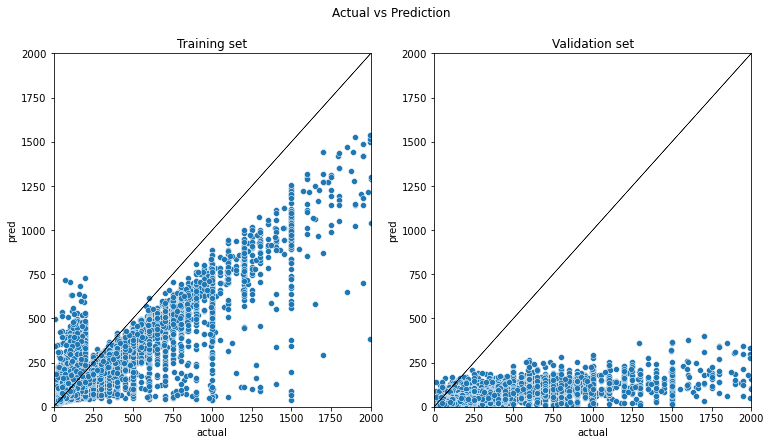

In [36]:
fig = plt.figure(figsize=(12.5, 6.5))
plt.suptitle('Actual vs Prediction')

plt.subplot(1, 2, 1)
ax = sns.scatterplot(pred_train['actual'], pred_train['pred'])
plt.plot(pred_train['actual'], pred_train['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_title('Training set');
# plt.axes().set_aspect('equal')
plt.subplot(1, 2, 2)
ax = sns.scatterplot(pred_valid['actual'], pred_valid['pred'])
plt.plot(pred_valid['actual'], pred_valid['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
plt.title('Validation set');

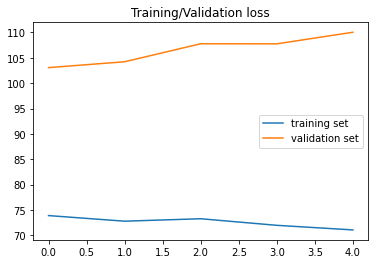

In [37]:
plt.plot(metrics['train_losses'], label='training set')
plt.plot(metrics['valid_losses'], label='validation set')
plt.title('Training/Validation loss')
plt.legend();

# Submission

In [38]:
pred_test_dfs = [pd.read_csv(os.path.join(output_dir, f'cv_fold{i + 1}_test.csv')) for i in range(N_SPLITS)]

In [39]:
pred_test = pd.concat(pred_test_dfs).groupby('id').sum()
pred_test = pred_test / N_SPLITS

In [40]:
pred_test.to_csv(os.path.join(output_dir, f'{EXPERIMENT}_submission.csv'), header=None)

# Visualization

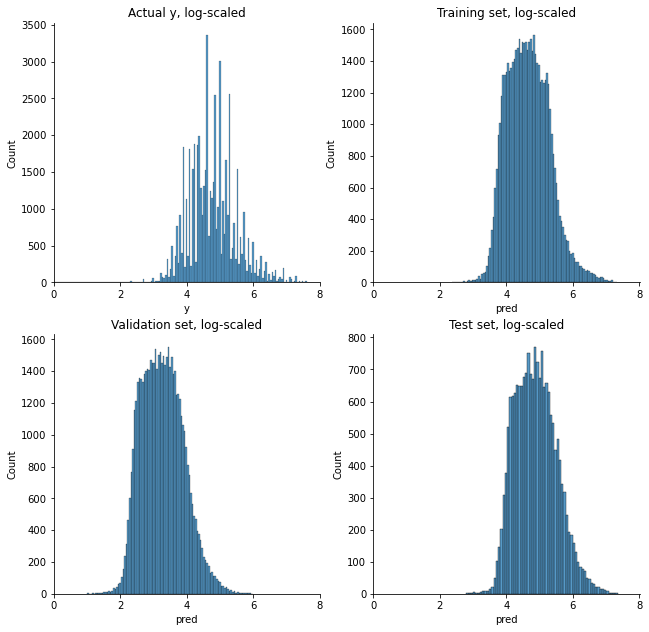

In [41]:
ylim_min, ylim_max = np.log(y_min * CLIP_LOWER_RATE), np.log(y_max * CLIP_UPPER_RATE)
fig = plt.figure(figsize=(10.5, 10.5))
plt.subplot(2, 2, 1)
ax = sns.histplot(y_log)
ax.set_title('Actual y, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 2)
ax = sns.histplot(np.log(pred_train['pred']))
ax.set_title('Training set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 3)
ax = sns.histplot(np.log(pred_valid['pred']))
ax.set_title('Validation set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 4)
ax = sns.histplot(np.log(pred_test['pred']))
ax.set_title('Test set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

fig.savefig(os.path.join(output_dir, 'figure.png'))

In [42]:
logger.debug('Complete({:.3f} seconds passed)'.format(time.time() - SINCE))

# Feature importance

In [43]:
pd.options.display.float_format = '{:.5f}'.format

In [44]:
models = []
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1

    ## モデルの保存
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'rb') as f:
        model = pickle.load(f)
    models.append(model)

AttributeError: 'StackingRegressor' object has no attribute 'feature_importances_'

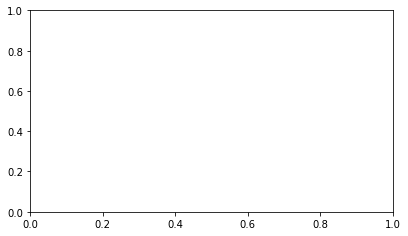

In [45]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model['class0'].feature_importances_, columns=['importance'])
    imp_df['feature'] = X_train.columns.tolist()
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance0.png'))

In [ ]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model['class1'].feature_importances_, columns=['importance'])
    imp_df['feature'] = X_train.columns.tolist()
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance0.png'))

# Error

In [ ]:
pred_valid = pd.read_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [ ]:
pred_valid['diff'] = pred_valid['pred'] - pred_valid['actual']

In [ ]:
fig = plt.figure()
plt.axes().set_aspect('equal')
ax = sns.scatterplot(data=pred_valid, x='actual', y='pred')
ax = sns.lineplot(data=pred_valid, x='actual', y='actual', color='red')
fig.savefig(os.path.join(output_dir, 'compare_actual_prediction.png'))

In [ ]:
pred_valid.describe()
sns.histplot(data=pred_valid, x='diff')
sns.despine()

In [ ]:
diff_df = pd.merge(X, pred_valid[['id', 'diff']]).set_index('id')

In [ ]:
%%time
import sweetviz
report = sweetviz.analyze(diff_df, target_feat='diff', pairwise_analysis='off')
report.show_html(os.path.join(output_dir, ('sweetviz_error_report.html')))

In [ ]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = diff_df.shape[1]

In [ ]:
diff_df.sort_values('diff').head(50)

In [ ]:
diff_df.sort_values('diff').tail(50)

In [ ]:
diff_df.corr()

In [ ]:
diff_df.corr().sort_values('diff')['diff'].head(50)

In [ ]:
from lightgbm import LGBMRegressor
estimator = LGBMRegressor(random_state=SEED, n_jobs=-1, importance_type='gain').fit(diff_df.drop(columns=['diff']), diff_df['diff'])

In [ ]:
imp_df = pd.DataFrame(data=estimator.feature_importances_, columns=['importance'])

In [ ]:
imp_df['feature'] = estimator.feature_name_

In [ ]:
imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
imp_df

In [ ]:
imp_df.to_csv(os.path.join(output_dir, 'diff_feature_importances.csv'), index=False)